In [7]:
from datetime import datetime
from meteostat import Stations, Daily
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint

In [8]:
cocoa_regions = {
    "Cameroon": {
        "Centre": {"lat": 4.5, "lon": 11.5},
        "Littoral": {"lat": 4.05, "lon": 9.7},
        "South-West": {"lat": 5.41667, "lon": 9.33333}  
    },
    "Côte d'Ivoire": {
        "Bas-Sassandra": {"lat": 5.5, "lon": -6.2},  
        "Sassandra-Marahoué": {"lat": 6.88033480, "lon": -6.23759470}  
    },
    "Ghana": {
        "Western": {"lat": 5.45, "lon": -2.12},  
        "Ashanti": {"lat": 6.75, "lon": -1.5},  
        "Eastern": {"lat": 6.5, "lon": -0.5}  
    },
    "Indonesia": {
        "Sulawesi": {"lat": -2.0, "lon": 121.0},  
        "Sumatra Nord": {"lat": 3.597031, "lon": 98.678513}  
    },
    "Ecuador": {
        "Guayas": {"lat": -2.31667, "lon": -80.4},  
        "Manabí": {"lat": -1.05, "lon": -80.47},
        "Los Ríos": {"lat": -1.5, "lon": -79.73},  
        "Esmeraldas": {"lat": 0.9592, "lon": -79.6531}  
    }
}
print(cocoa_regions)

{'Cameroon': {'Centre': {'lat': 4.5, 'lon': 11.5}, 'Littoral': {'lat': 4.05, 'lon': 9.7}, 'South-West': {'lat': 5.41667, 'lon': 9.33333}}, "Côte d'Ivoire": {'Bas-Sassandra': {'lat': 5.5, 'lon': -6.2}, 'Sassandra-Marahoué': {'lat': 6.8803348, 'lon': -6.2375947}}, 'Ghana': {'Western': {'lat': 5.45, 'lon': -2.12}, 'Ashanti': {'lat': 6.75, 'lon': -1.5}, 'Eastern': {'lat': 6.5, 'lon': -0.5}}, 'Indonesia': {'Sulawesi': {'lat': -2.0, 'lon': 121.0}, 'Sumatra Nord': {'lat': 3.597031, 'lon': 98.678513}}, 'Ecuador': {'Guayas': {'lat': -2.31667, 'lon': -80.4}, 'Manabí': {'lat': -1.05, 'lon': -80.47}, 'Los Ríos': {'lat': -1.5, 'lon': -79.73}, 'Esmeraldas': {'lat': 0.9592, 'lon': -79.6531}}}


In [9]:
# Define the date range
start = datetime(1960, 1, 1)
end = datetime(2025, 12, 31)

# List to store our results
results = []

# Loop through each country and location in the test dictionary
for country, areas in cocoa_regions.items():
    for area, coords in areas.items():
        lat = coords['lat']
        lon = coords['lon']
        print(f"\n\n=== {country} - {area} ===")
        print(f"Coordinates: Latitude = {lat}, Longitude = {lon}")
        
        # Search for nearby stations and fetch top 5 stations
        stations = Stations().nearby(lat, lon).fetch(5)
        print("Available stations (showing distance):")
        print(stations[['distance']])
        
        # Loop through each station returned
        for station_id in stations.index:
            data = Daily(station_id, start, end).fetch()
            if not data.empty:
                print(f"\nData found for station: {station_id}")
                print(data.head())
                # For each day, add a record with the daily data
                for date, row in data.iterrows():
                    # Extract the year from the date index
                    year = date.year
                    record = {
                        "country": country,
                        "date": date,
                        "id": station_id,
                        "year": year,
                        "tavg_daily": row.get("tavg"),
                        "tmin_daily": row.get("tmin"),
                        "tmax_daily": row.get("tmax"),
                        "prcp_daily": row.get("prcp"),
                        "snow_daily": row.get("snow"),
                        "wdir_daily": row.get("wdir"),
                        "wspd_daily": row.get("wspd"),
                        "wpgt_daily": row.get("wpgt"),
                        "pres_daily": row.get("pres")
                    }
                    results.append(record)
            else:
                # If no data was returned, add one record with NA for weather values
                print(f"No data for station {station_id} in {country} - {area}")
                record = {
                    "country": country,
                    "id": station_id,
                    "year": None,
                    "tavg_daily": None,
                    "tmin_daily": None,
                    "tmax_daily": None,
                    "prcp_daily": None,
                    "snow_daily": None,
                    "wdir_daily": None,
                    "wspd_daily": None,
                    "wpgt_daily": None,
                    "pres_daily": None
                }
                results.append(record)

# Convert the list of records into a DataFrame
df_out = pd.DataFrame(results)

# Save the DataFrame to a CSV file with semicolon delimiter
output_csv = "cocoa_weather_data.csv"
df_out.to_csv(output_csv, sep=";", index=False)

print(f"\nData saved to {output_csv}")




=== Cameroon - Centre ===
Coordinates: Latitude = 4.5, Longitude = 11.5
Available stations (showing distance):
            distance
id                  
64920   37957.052515
64950   74156.788144
FKKY0   74225.583952
FKKE0  124692.279606
64900  151154.949733

Data found for station: 64920
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2021-04-29  25.5  21.7  32.0   0.0   NaN   32.0   5.4   NaN  1010.5   NaN
2021-04-30  25.8  19.9  31.4   0.0   NaN  216.0   4.8   NaN  1010.0   NaN
2021-05-01  25.5  22.8  31.0   2.4   NaN  190.0   4.5   NaN  1010.1   NaN
2021-05-02  25.9  21.3  32.4   3.3   NaN  199.0   5.3   NaN  1009.5   NaN
2021-05-03  24.5  21.4  28.3   5.0   NaN  167.0   4.9   NaN  1010.7   NaN

Data found for station: 64950
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
1981-03-24  27.3  

In [10]:
#print the end of the table to check if the data is correct
print(df_out)

         country       date     id    year  tavg_daily  tmin_daily  \
0       Cameroon 2021-04-29  64920  2021.0        25.5        21.7   
1       Cameroon 2021-04-30  64920  2021.0        25.8        19.9   
2       Cameroon 2021-05-01  64920  2021.0        25.5        22.8   
3       Cameroon 2021-05-02  64920  2021.0        25.9        21.3   
4       Cameroon 2021-05-03  64920  2021.0        24.5        21.4   
...          ...        ...    ...     ...         ...         ...   
475949   Ecuador 2025-04-08  84105  2025.0        24.4        22.4   
475950   Ecuador 2025-04-09  84105  2025.0        24.1        22.4   
475951   Ecuador 2025-04-10  84105  2025.0        23.8        21.8   
475952   Ecuador 2025-04-11  84105  2025.0        24.2        21.6   
475953   Ecuador 2025-04-12  84105  2025.0        24.8        21.7   

        tmax_daily  prcp_daily  snow_daily  wdir_daily  wspd_daily  \
0             32.0         0.0         NaN        32.0         5.4   
1             31.4 

In [11]:
import pandas as pd
import logging

def setup_logging():
    """
    Configure la journalisation avec un niveau de DEBUG.
    """
    logging.basicConfig(level=logging.DEBUG,
                        format="%(asctime)s - %(levelname)s - %(message)s")

def load_csv(file_path, sep=','):
    """
    Charge un fichier CSV avec le séparateur spécifié et retourne un DataFrame pandas.
    En cas d'erreur, log l'erreur et lève l'exception.
    """
    try:
        df = pd.read_csv(file_path, sep=sep)
        logging.debug(f"Chargement de {file_path} réussi avec {df.shape[0]} lignes et {df.shape[1]} colonnes.")
        return df
    except Exception as e:
        logging.error(f"Erreur lors du chargement de {file_path} : {e}")
        raise

def standardize_columns(weather_df, production_df):
    """
    Harmonise les noms des colonnes entre les deux DataFrames.
    
    Pour production_df, renomme 'Country' en 'country' et 'Year' en 'year'.
    Pour weather_df, s'il y a des problèmes, on peut appliquer des corrections.
    """
    if 'Country' in production_df.columns:
        production_df = production_df.rename(columns={'Country': 'country'})
        logging.debug("Colonne 'Country' renommée en 'country' dans le DataFrame de production.")
    if 'Year' in production_df.columns:
        production_df = production_df.rename(columns={'Year': 'year'})
        logging.debug("Colonne 'Year' renommée en 'year' dans le DataFrame de production.")
    
    # Pour le DataFrame météo, s'il y a des espaces ou autre, on peut aussi uniformiser
    weather_df.columns = weather_df.columns.str.strip().str.lower()
    logging.debug(f"Colonnes du DataFrame météo après normalisation : {list(weather_df.columns)}")
    
    return weather_df, production_df

def merge_data(weather_df, production_df):
    """
    Fusionne les DataFrames weather_df et production_df sur les colonnes 'country' et 'year'.
    
    - Dans weather_df, si la colonne 'date' est présente, on peut y extraire l'année si besoin.
    - On effectue une jointure à gauche pour conserver toutes les entrées journalières.
    """
    # Si la colonne 'date' est présente et que 'year' n'est pas correcte (ou à confirmer),
    # on peut tenter une extraction. Ici, on suppose que weather_df possède déjà la colonne 'year'
    if 'date' in weather_df.columns and weather_df['year'].isnull().all():
        try:
            weather_df['year'] = pd.to_datetime(weather_df['date'], errors='coerce').dt.year
            logging.debug("Extraction de l'année depuis la colonne 'date' réussie.")
        except Exception as e:
            logging.error(f"Erreur lors de l'extraction de l'année depuis 'date' : {e}")
            raise
    else:
        logging.warning("La colonne 'date' n'est pas utilisée pour l'extraction, on suppose que 'year' est déjà présente.")
    
    logging.debug(f"DataFrame météo avant fusion:\n{weather_df.head()}")
    logging.debug(f"DataFrame production avant fusion:\n{production_df.head()}")

    # Fusionner les deux DataFrames sur 'country' et 'year'
    try:
        merged_df = pd.merge(weather_df, production_df, how="left", on=["country", "year"])
        logging.debug("Fusion des DataFrames réussie.")
        logging.debug(f"DataFrame fusionné a {merged_df.shape[0]} lignes et {merged_df.shape[1]} colonnes.")
    except Exception as e:
        logging.error(f"Erreur lors de la fusion des DataFrames : {e}")
        raise

    return merged_df

def main():
    setup_logging()

    # Définition des fichiers CSV à charger.
    # Le fichier météo utilise le point-virgule comme séparateur.
    weather_file = "cocoa_weather_data.csv"
    production_file = "FAOSTAT_cacao.csv"
    
    logging.info("Début du chargement des fichiers CSV...")

    # Chargement des données
    weather_df = load_csv(weather_file, sep=';')
    production_df = load_csv(production_file)  # Séparateur par défaut : virgule
    
    logging.info("Fichiers chargés avec succès. Début de l'harmonisation des colonnes...")
    
    # Harmonisation des noms de colonnes pour les deux DataFrames
    weather_df, production_df = standardize_columns(weather_df, production_df)
    
    logging.info("Colonnes harmonisées. Début de la fusion des données...")
    
    # Fusionner les DataFrames
    merged_df = merge_data(weather_df, production_df)
    
    # Sauvegarder le résultat dans un nouveau fichier CSV
    output_file = "merged_data.csv"
    try:
        merged_df.to_csv(output_file, index=False)
        logging.info(f"Les données fusionnées ont été enregistrées dans {output_file}")
    except Exception as e:
        logging.error(f"Erreur lors de l'enregistrement du fichier fusionné : {e}")

if __name__ == "__main__":
    main()


2025-04-13 14:19:11,674 - INFO - Début du chargement des fichiers CSV...


2025-04-13 14:19:12,311 - DEBUG - Chargement de cocoa_weather_data.csv réussi avec 475954 lignes et 13 colonnes.
2025-04-13 14:19:12,339 - DEBUG - Chargement de FAOSTAT_cacao.csv réussi avec 315 lignes et 7 colonnes.
2025-04-13 14:19:12,341 - INFO - Fichiers chargés avec succès. Début de l'harmonisation des colonnes...
2025-04-13 14:19:12,344 - DEBUG - Colonne 'Country' renommée en 'country' dans le DataFrame de production.
2025-04-13 14:19:12,345 - DEBUG - Colonne 'Year' renommée en 'year' dans le DataFrame de production.
2025-04-13 14:19:12,347 - DEBUG - Colonnes du DataFrame météo après normalisation : ['country', 'date', 'id', 'year', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily']
2025-04-13 14:19:12,348 - INFO - Colonnes harmonisées. Début de la fusion des données...
2025-04-13 14:19:12,351 - WARNING - La colonne 'date' n'est pas utilisée pour l'extraction, on suppose que 'year' est déjà présente.
2025-

I need to merge the data from both csv based on country and year

In [12]:
import pandas as pd
import numpy as np

# Chemins d'accès
input_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_data.csv"
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\preprocessed_data.csv"

# 1. Charger le CSV complet (en supposant des séparateurs par virgule)
df = pd.read_csv(input_csv, sep=",", encoding="utf-8", low_memory=False)
print("Taille initiale du DataFrame :", df.shape)
print("Colonnes initiales :", df.columns.tolist())

# Si le DataFrame a une seule colonne (problème de séparation), le rescinder avec la virgule
if df.shape[1] == 1:
    print("Le DataFrame a une seule colonne, on tente de le rescinder...")
    df = df.iloc[:, 0].str.split(",", expand=True)
    new_header = df.iloc[0]  # première ligne comme header
    df = df[1:]
    df.columns = new_header
    print("Colonnes après rescindage :", df.columns.tolist())
    print("Taille du DataFrame après rescindage :", df.shape)

# 2. Harmonisation des colonnes
# Renommer "Value" en "production_yearly" si besoin
if 'production_yearly' not in df.columns and 'Value' in df.columns:
    df.rename(columns={'Value': 'production_yearly'}, inplace=True)
    print("La colonne 'Value' a été renommée en 'production_yearly'.")

# Supprimer les colonnes inutiles générées automatiquement (colonnes "Unnamed")
unnamed_cols = [col for col in df.columns if col.startswith("Unnamed")]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)
    print("Colonnes supprimées :", unnamed_cols)
    
# Supprimer les colonnes 'id' et 'year' car elles sont redondantes avec la colonne 'date'
cols_to_drop = [col for col in ['id', 'year'] if col in df.columns]
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print("Colonnes supprimées :", cols_to_drop)
    
print("Colonnes après harmonisation :", df.columns.tolist())

# 3. Définir la liste des colonnes d'intérêt pour l'analyse
feature_cols = [
    'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily',
    'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily',
    'pres_daily', 'production_yearly'
]

# Vérifier la présence de toutes les colonnes d'intérêt
missing_cols = [col for col in feature_cols if col not in df.columns]
if missing_cols:
    print("Attention, les colonnes suivantes sont absentes :", missing_cols)

# 4. Conversion des colonnes d'intérêt en valeurs numériques
for col in feature_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 6. Imputer les valeurs manquantes dans les colonnes d'intérêt avec la moyenne de la colonne
for col in feature_cols:
    if col in df.columns:
        mean_val = df[col].mean()
        # Si la colonne ne contient que des NaN, utiliser 0 comme valeur de remplissage
        if pd.isna(mean_val):
            fill_val = 0
            print(f"La colonne '{col}' ne contient que des NaN. Remplissage avec 0.")
        else:
            fill_val = mean_val
        df[col] = df[col].fillna(fill_val)
        print(f"{col} : {df[col].isna().sum()} NaN après imputation.")

# 7. Supprimer les lignes restantes contenant encore des NaN dans les colonnes d'intérêt
df = df.dropna(subset=feature_cols)
print("Taille du DataFrame après imputation (et dropna éventuel) :", df.shape)

# 8. Arrondir toutes les valeurs numériques à 0.001 près (trois décimales)
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].round(3)
print("Arrondissement effectué sur les colonnes numériques.")

# 9. Enregistrer le DataFrame prétraité dans un nouveau CSV avec le séparateur point-virgule
df.to_csv(output_csv, sep=";", index=False)
print(f"Prétraitement terminé. Le fichier prétraité a été enregistré sous {output_csv}")


Taille initiale du DataFrame : (475954, 18)
Colonnes initiales : ['country', 'date', 'id', 'year', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'Value', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
La colonne 'Value' a été renommée en 'production_yearly'.
Colonnes supprimées : ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']
Colonnes supprimées : ['id', 'year']
Colonnes après harmonisation : ['country', 'date', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly']
tavg_daily : 0 NaN après imputation.
tmin_daily : 0 NaN après imputation.
tmax_daily : 0 NaN après imputation.
prcp_daily : 0 NaN après imputation.
La colonne 'snow_daily' ne contient que des NaN. Remplissage avec 0.
snow_daily : 0 NaN après imputation.
wdir_daily : 0 NaN après imputation.
wspd_daily : 0 NaN après imputation.
La colonne

In [83]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # Pour réduire les avertissements inutiles

# --- Fonctions de debugage ---
def debug_print(message):
    print(f"[DEBUG] {message}")

def debug_shape(df, name="DataFrame"):
    debug_print(f"{name} shape: {df.shape}")

def debug_columns(df, name="DataFrame"):
    debug_print(f"{name} colonnes: {df.columns.tolist()}")

# --- Chargement et préparation du DataFrame ---
def load_and_prepare_data(input_csv):
    debug_print("Étape 1 : Chargement du CSV et préparation du DataFrame")
    df = pd.read_csv(input_csv, sep=";", low_memory=False)
    debug_shape(df, "Données initiales")
    debug_columns(df, "Données initiales")
    
    # Extraction de 'year' et 'month' à partir de 'date', si présente
    if 'date' in df.columns:
        debug_print("Conversion de 'date' en datetime")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        debug_print("Exemple de date et extraction")
        print(df[['date', 'year', 'month']].head())
    else:
        # Si la colonne 'date' n'est pas présente, on vérifie que 'year' et 'month' existent
        if 'year' not in df.columns or 'month' not in df.columns:
            raise KeyError("Impossible d'extraire 'year' et 'month' car ni 'date' ni les colonnes 'year' et 'month' ne sont présentes.")
    
    # Supprimer les lignes où 'year' ou 'month' est manquant
    nb_avant = df.shape[0]
    df.dropna(subset=['year', 'month'], inplace=True)
    nb_apres = df.shape[0]
    debug_print(f"Lignes supprimées lors de la vérification de 'year' et 'month' : {nb_avant - nb_apres}")
    
    # Conversion en entier
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    
    # Suppression de la colonne 'id' si présente
    cols_a_supprimer = [col for col in ['id'] if col in df.columns]
    if cols_a_supprimer:
        df.drop(columns=cols_a_supprimer, inplace=True)
        debug_print(f"Colonnes supprimées : {cols_a_supprimer}")
    
    debug_columns(df, "Colonnes finales après préparation")
    return df

# --- Calcul de la "valeur historique" par enregistrement ---
def compute_historical_values(df, weather_cols):
    debug_print("Étape 2 : Calcul de la moyenne historique cumulée par (country, month)")
    # On trie par country, month et year pour s'assurer que l'ordre chronologique est respecté
    df = df.sort_values(by=['country', 'month', 'year']).copy()
    debug_print("Exemple de tri chronologique (country, year, month) :")
    print(df[['country', 'year', 'month']].head(10))
    
    # Pour chacune des variables météo, calcul de la moyenne cumulative historique
    for col in weather_cols:
        debug_print(f"Calcul de la moyenne historique pour {col}")
        df[col + '_historical'] = df.groupby(['country', 'month'])[col] \
            .transform(lambda x: x.expanding(min_periods=1).mean().shift(1))
        # Pour le premier enregistrement de chaque groupe, imputation avec la moyenne globale du groupe
        df[col + '_historical'] = df.groupby(['country', 'month'])[col + '_historical'] \
            .transform(lambda x: x.fillna(x.mean()))
        debug_print(f"Aperçu de {col} et {col}_historical:")
        print(df[['country', 'year', 'month', col, col + '_historical']].head(10))
    return df

# --- Calcul de la différence entre la valeur journalière et la valeur historique ---
def compute_differences(df, weather_cols):
    debug_print("Étape 3 : Calcul de la différence entre la valeur quotidienne et la valeur historique")
    for col in weather_cols:
        df[col + '_diff'] = df[col] - df[col + '_historical']
        debug_print(f"Aperçu de {col}_diff :")
        print(df[['country', 'year', 'month', col, col + '_historical', col + '_diff']].head(10))
    return df

# --- Arrondi des valeurs numériques ---
def round_numeric_values(df):
    debug_print("Étape 4 : Arrondissement des colonnes numériques")
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].round(3)
    debug_print("Exemple après arrondi :")
    print(df.head(10))
    return df

# --- Enregistrement du DataFrame final ---
def save_final_data(df, output_csv):
    df.to_csv(output_csv, sep=";", index=False)
    debug_print(f"Le DataFrame final a été enregistré dans {output_csv}")

# --- Main ---
if __name__ == "__main__":
    # Chemins d'accès aux fichiers CSV
    input_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\preprocessed_data.csv"
    output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data_hist.csv"
    
    # Chargement et préparation
    df = load_and_prepare_data(input_csv)
    
    # Définition des variables météo à traiter.
    # Adaptées du code initial : on prend toutes les colonnes d'intérêt sauf 'production_yearly'
    agg_funcs = {
        'tavg_daily': 'mean',
        'tmin_daily': 'mean',
        'tmax_daily': 'mean',
        'prcp_daily': 'sum',
        'snow_daily': 'sum',
        'wdir_daily': 'mean',
        'wspd_daily': 'mean',
        'wpgt_daily': 'mean',
        'pres_daily': 'mean',
        'production_yearly': 'first'
    }
    weather_cols = list(agg_funcs.keys())
    if 'production_yearly' in weather_cols:
        weather_cols.remove('production_yearly')
    debug_print(f"Variables météo à traiter pour l'historique : {weather_cols}")
    
    # Calcul de la moyenne historique pour chaque enregistrement
    df = compute_historical_values(df, weather_cols)
    
    # Calcul des différences
    df = compute_differences(df, weather_cols)
    
    # Arrondi des valeurs numériques
    df = round_numeric_values(df)
    
    # Enregistrement final
    save_final_data(df, output_csv)
    print("Traitement terminé.")


[DEBUG] Étape 1 : Chargement du CSV et préparation du DataFrame
[DEBUG] Données initiales shape: (475954, 12)
[DEBUG] Données initiales colonnes: ['country', 'date', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly']
[DEBUG] Conversion de 'date' en datetime
[DEBUG] Exemple de date et extraction
        date    year  month
0 2021-04-29  2021.0    4.0
1 2021-04-30  2021.0    4.0
2 2021-05-01  2021.0    5.0
3 2021-05-02  2021.0    5.0
4 2021-05-03  2021.0    5.0
[DEBUG] Lignes supprimées lors de la vérification de 'year' et 'month' : 3
[DEBUG] Colonnes finales après préparation colonnes: ['country', 'date', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'year', 'month']
[DEBUG] Variables météo à traiter pour l'historique : ['tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wd

Now that i have fetch all the required data i will use random forest to see if the weather can impact the production of wheat in the country

cointégration, kurtosis, correl, skewness, test student, test de stationnairté

First attempt aggregate daily data into annual

On a fini la partie formatage des données

On va pouvoir commencer à faire des tests statistiques pour repérer les paramètres les plus impactant

Taille du DataFrame chargé : (3532, 31)
Colonnes chargées : ['country', 'year', 'month', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Colonne 'tavg_daily_diff' calculée.
Colonne 'tmin_daily_diff' calculée.
Colonne 'tmax_daily_diff' calculée.
Colonne 'prcp_daily_diff' calculée.
Colonne 'snow_daily_diff' calculée.
Colonne 'wdir_daily_diff' calculée.
Colonne 'wspd_daily_diff' calculée.
Colonne 'wpgt_daily_diff' calculée.
Colonne 'pres_daily_diff' calculée.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   21.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   21.9s remaining:   43.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   21.9s remaining:   27.4s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   21.9s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   21.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   21.9s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.9s finished
2025-04-13 14:19:48,103 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA0FCF440>



Résultats des tests sur les différences (daily - historical) :
     variable  n_obs_diff     t_stat      t_p_value   adf_stat   adf_p_value  \
0  tavg_daily        3532  -1.017083   3.091838e-01  -8.794495  2.195065e-14   
1  tmin_daily        3532  12.668770   5.289126e-36  -6.359068  2.500480e-08   
2  tmax_daily        3532   6.951303   4.292333e-12  -8.596433  7.057049e-14   
3  prcp_daily        3532  28.956223  1.329264e-165 -13.443615  3.802636e-25   
4  snow_daily        3532        NaN            NaN        NaN           NaN   
5  wdir_daily        3532  -0.099543   9.207128e-01 -15.856956  9.307262e-29   
6  wspd_daily        3532  -0.234531   8.145863e-01  -7.192132  2.487850e-10   
7  wpgt_daily        3532        NaN            NaN        NaN           NaN   
8  pres_daily        3532  -0.081263   9.352372e-01 -14.458947  6.898393e-27   

   shapiro_stat  shapiro_p_value  coint_p_value  
0      0.941844     3.471053e-35   8.492345e-11  
1      0.939485     9.604463e-36   

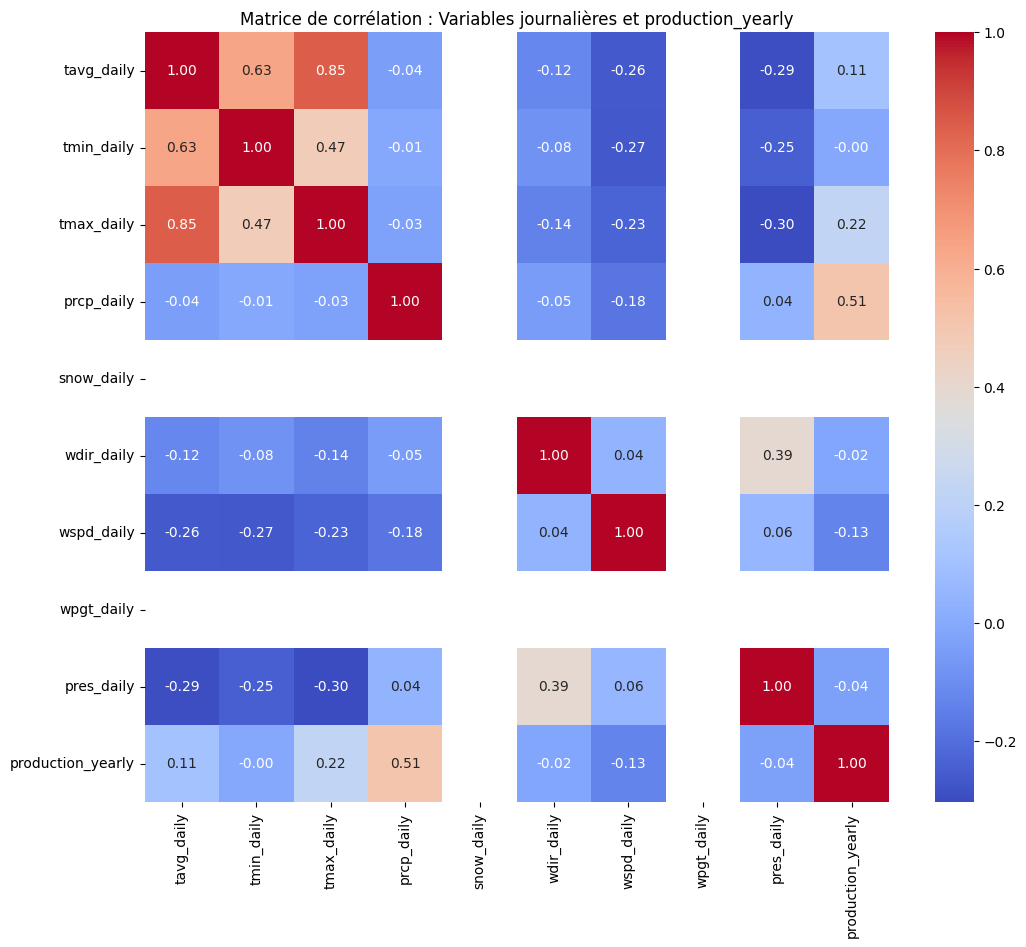

2025-04-13 14:19:48,752 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015E9F5F58E0>


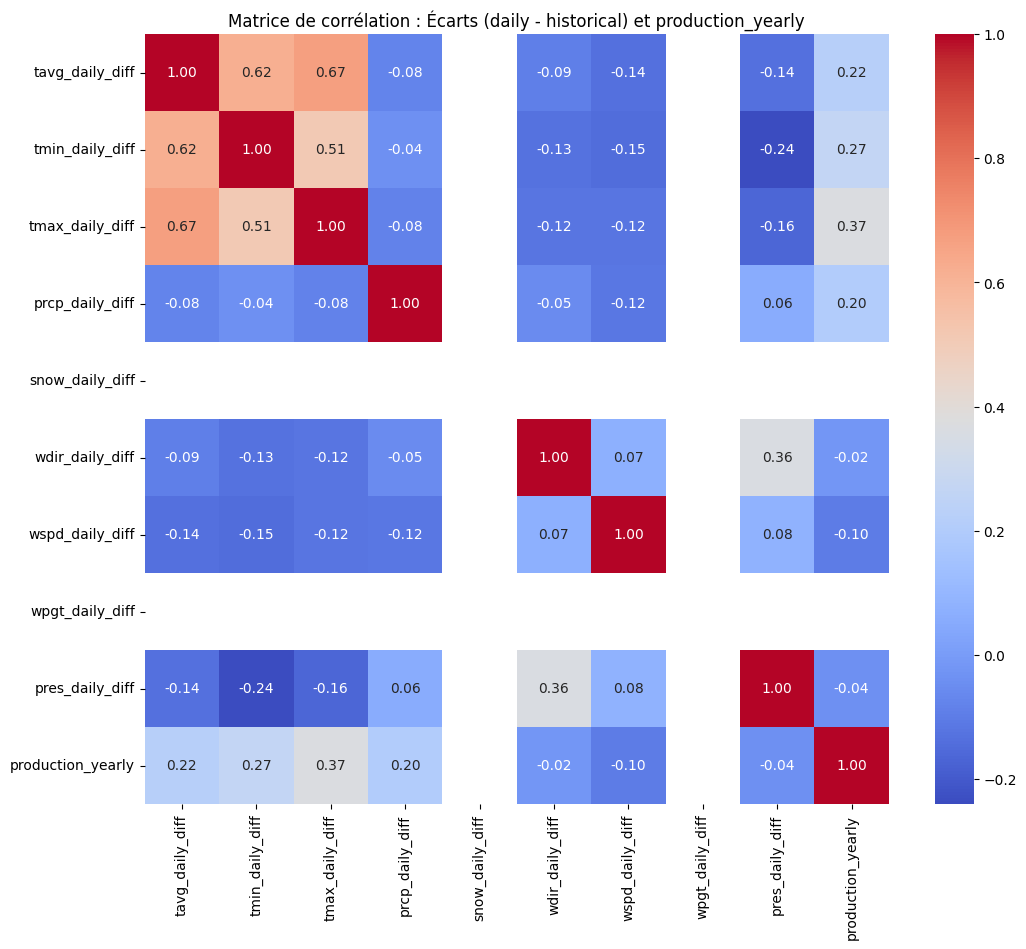


Les résultats des tests classiques ont été enregistrés dans C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_result.csv
Les résultats du test de Jarque-Bera ont été enregistrés dans C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_result_jarquebera.csv


In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# ---------------------------
# 1. Charger le CSV agrégé nettoyé
# ---------------------------
input_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data.csv"
df = pd.read_csv(input_csv, sep=";", low_memory=False)
print("Taille du DataFrame chargé :", df.shape)
print("Colonnes chargées :", df.columns.tolist())

# ---------------------------
# 2. Calcul des colonnes de différence : diff = daily - historical
# Pour chaque variable météo, on suppose qu'il existe une colonne <variable>_historical.
weather_vars = ['tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 
                'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily']

for var in weather_vars:
    historical_col = var + "_historical"
    diff_col = var + "_diff"
    if historical_col in df.columns:
        df[diff_col] = df[var] - df[historical_col]
        print(f"Colonne '{diff_col}' calculée.")
    else:
        print(f"ATTENTION: la colonne '{historical_col}' est absente. Impossible de calculer '{diff_col}'.")

# ---------------------------
# 3. Définir une fonction pour exécuter les tests sur la série de différences d'une variable
# ---------------------------
def run_tests(var, df):
    daily_col = var  # Valeur journalière
    historical_col = var + "_historical"  # Valeur historique
    diff_col = var + "_diff"  # Différence (daily - historical)
    
    # Calculer la série de différence
    if daily_col in df.columns and historical_col in df.columns:
        diff_series = df[daily_col] - df[historical_col]
    else:
        diff_series = pd.Series(dtype=float)
    diff_series = diff_series.dropna()
    n_obs = len(diff_series)
    
    # Test t de Student (H0: moyenne(diff) = 0)
    if n_obs > 0:
        t_stat, t_p_val = stats.ttest_1samp(diff_series, popmean=0)
    else:
        t_stat, t_p_val = np.nan, np.nan
        
    # Test ADF pour la stationnarité sur la série des différences
    try:
        adf_result = adfuller(diff_series)
        adf_stat = adf_result[0]
        adf_p_val = adf_result[1]
    except Exception as e:
        print(f"Erreur ADF pour {var}: {e}")
        adf_stat, adf_p_val = np.nan, np.nan
        
    # Test de normalité (Shapiro)
    try:
        shapiro_stat, shapiro_p = stats.shapiro(diff_series)
    except Exception as e:
        print(f"Erreur Shapiro pour {var}: {e}")
        shapiro_stat, shapiro_p = np.nan, np.nan
        
    # Test de cointégration entre la variable journalière et production_yearly
    if 'production_yearly' in df.columns and daily_col in df.columns:
        common = df[['production_yearly', daily_col]].dropna()
        if len(common) > 10:
            try:
                _, coint_p, _ = coint(common['production_yearly'], common[daily_col])
            except Exception as e:
                print(f"Erreur cointégration pour {var}: {e}")
                coint_p = np.nan
        else:
            coint_p = np.nan
    else:
        coint_p = np.nan
        
    return {
        'variable': var,
        'n_obs_diff': n_obs,
        't_stat': t_stat,
        't_p_value': t_p_val,
        'adf_stat': adf_stat,
        'adf_p_value': adf_p_val,
        'shapiro_stat': shapiro_stat,
        'shapiro_p_value': shapiro_p,
        'coint_p_value': coint_p
    }

# ---------------------------
# 4. Exécuter les tests en parallèle sur toutes les variables
# ---------------------------
results_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_tests)(var, df) for var in weather_vars
)
results_df = pd.DataFrame(results_list)
print("\nRésultats des tests sur les différences (daily - historical) :")
print(results_df)

# ---------------------------
# 5. Test de Jarque-Bera sur les écarts (Optionnel)
# ---------------------------
jb_results = []
for var in weather_vars:
    diff_col = var + "_diff"
    if diff_col in df.columns:
        diff_series = df[diff_col].dropna()
        if len(diff_series) > 0:
            jb_stat, jb_p = stats.jarque_bera(diff_series)
        else:
            jb_stat, jb_p = np.nan, np.nan
        jb_results.append({
            'variable': var,
            'n_obs_diff': len(diff_series),
            'jarque_bera_stat': jb_stat,
            'jarque_bera_p_val': jb_p
        })
    else:
        jb_results.append({
            'variable': var,
            'n_obs_diff': np.nan,
            'jarque_bera_stat': np.nan,
            'jarque_bera_p_val': np.nan
        })
df_jb = pd.DataFrame(jb_results)
print("\nRésultats du test de Jarque-Bera sur les écarts :")
print(df_jb)

# ---------------------------
# 6. Matrices de corrélation
# a) Corrélation entre les variables journalières et production_yearly
daily_vars = [var for var in weather_vars if var in df.columns]
cols_daily_corr = daily_vars + ['production_yearly']
corr_daily = df[cols_daily_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_daily, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Variables journalières et production_yearly")
plt.show()

# b) Corrélation entre les écarts (différences) et production_yearly
diff_vars = [var + "_diff" for var in weather_vars if var + "_diff" in df.columns]
cols_diff_corr = diff_vars + ['production_yearly']
corr_diff = df[cols_diff_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Écarts (daily - historical) et production_yearly")
plt.show()

# ---------------------------
# 7. Enregistrer les résultats des tests dans un CSV
# ---------------------------
# Enregistrement des tests classiques
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_result.csv"
results_df.to_csv(output_csv, sep=";", index=False)
print(f"\nLes résultats des tests classiques ont été enregistrés dans {output_csv}")

# Enregistrement des résultats du test de Jarque-Bera
output_csv_jb = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_result_jarquebera.csv"
df_jb.to_csv(output_csv_jb, sep=";", index=False)
print(f"Les résultats du test de Jarque-Bera ont été enregistrés dans {output_csv_jb}")


refaire les memes tests mais avec les quantiles

Taille du DataFrame chargé : (3532, 31)
Colonnes chargées : ['country', 'year', 'month', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Colonne 'tavg_daily_diff' calculée pour tavg_daily.
Colonne 'tmin_daily_diff' calculée pour tmin_daily.
Colonne 'tmax_daily_diff' calculée pour tmax_daily.
Colonne 'prcp_daily_diff' calculée pour prcp_daily.
Colonne 'snow_daily_diff' calculée pour snow_daily.
Colonne 'wdir_daily_diff' calculée pour wdir_daily.
Colonne 'wspd_daily_diff' calculée pour wspd_daily.
Colo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.6s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    2.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.6s finished
2025-04-13 14:19:52,280 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015E84F6BF50>



Résultats des tests sur les valeurs extrêmes (quantiles 1% et 99%) :
     variable  n_obs_diff  n_obs_extreme  lower_quantile  upper_quantile  \
0  tavg_daily        3532             72        -2.15494         1.46759   
1  tmin_daily        3532             72        -1.89700         1.56097   
2  tmax_daily        3532             72        -2.71596         1.80969   
3  prcp_daily        3532             72      -546.33801      2940.10543   
4  snow_daily        3532           3532         0.00000         0.00000   
5  wdir_daily        3532             72       -32.50919        22.27647   
6  wspd_daily        3532             72        -2.70081         3.63145   
7  wpgt_daily        3532           3532         0.00000         0.00000   
8  pres_daily        3532             72        -1.59487         1.91007   

     t_stat     t_p_value  adf_stat  adf_p_value  shapiro_stat  \
0 -1.968765  5.288430e-02 -2.856199     0.050684      0.804435   
1 -1.055376  2.948315e-01 -2.475196  

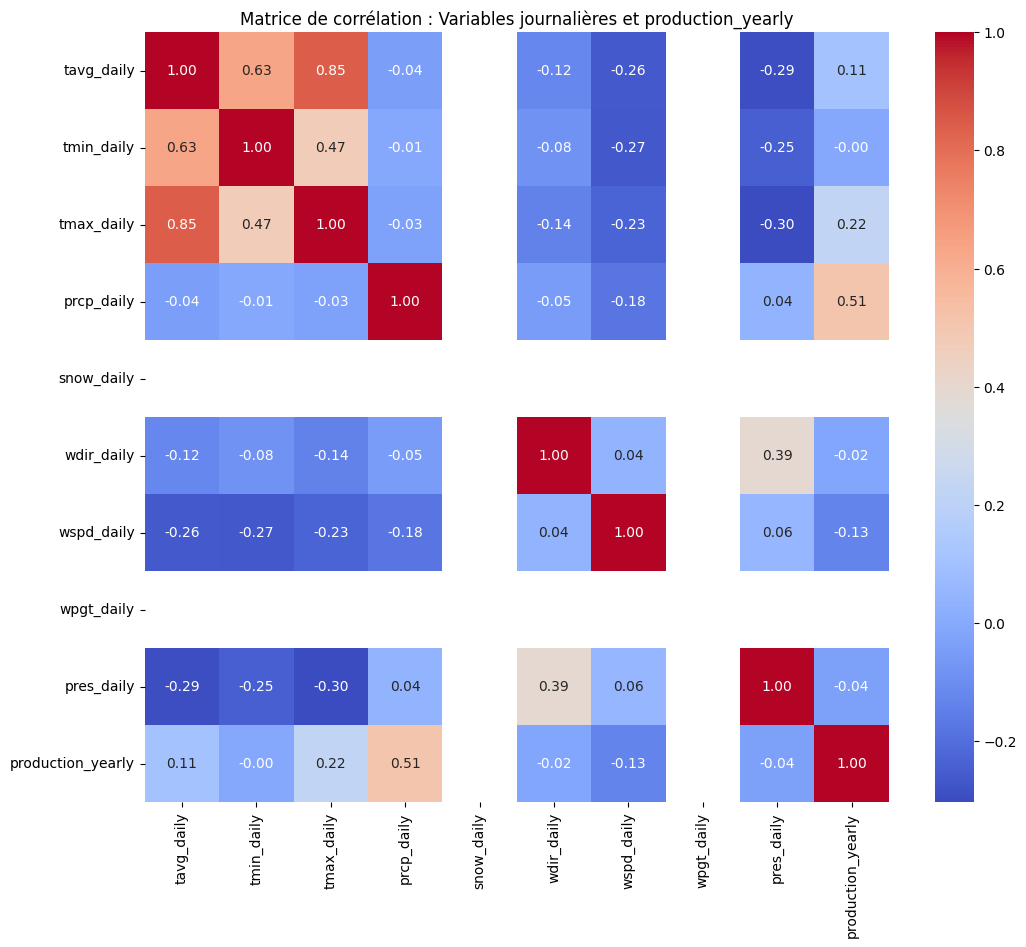

2025-04-13 14:19:52,955 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1EB8A70>


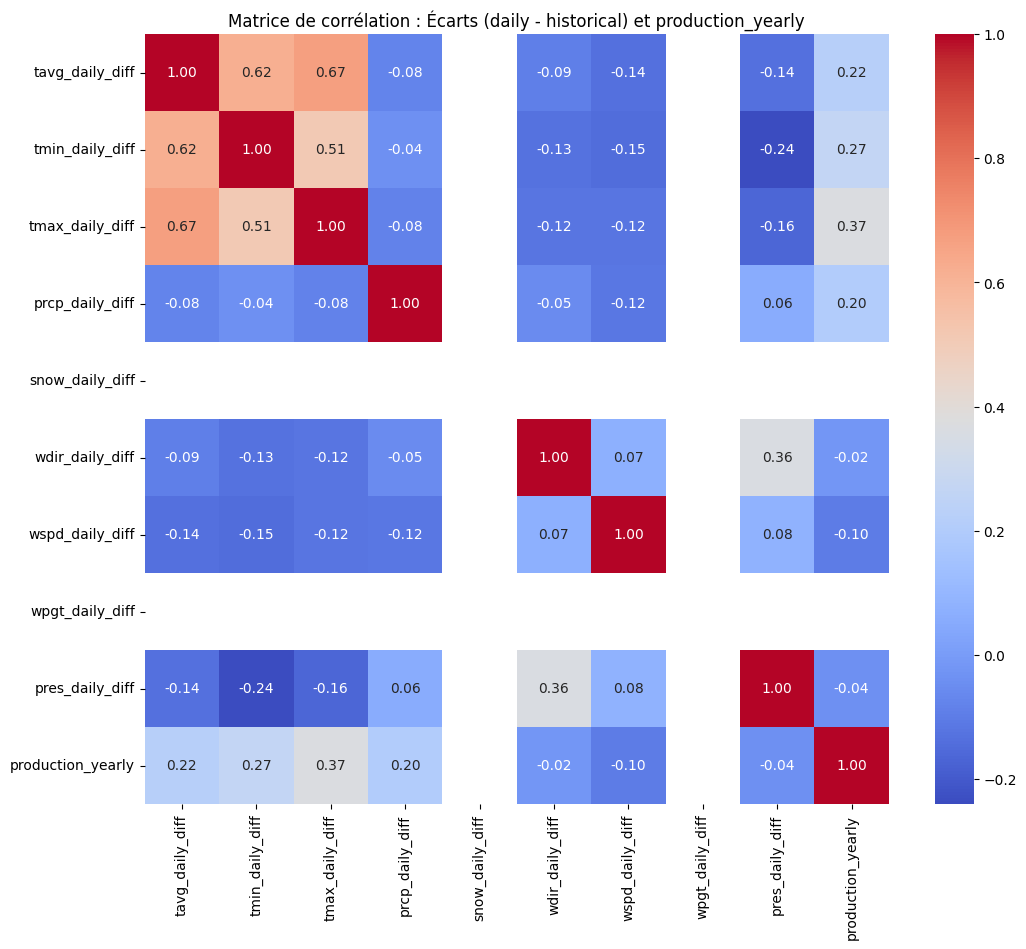

2025-04-13 14:19:53,618 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1C6BA40>


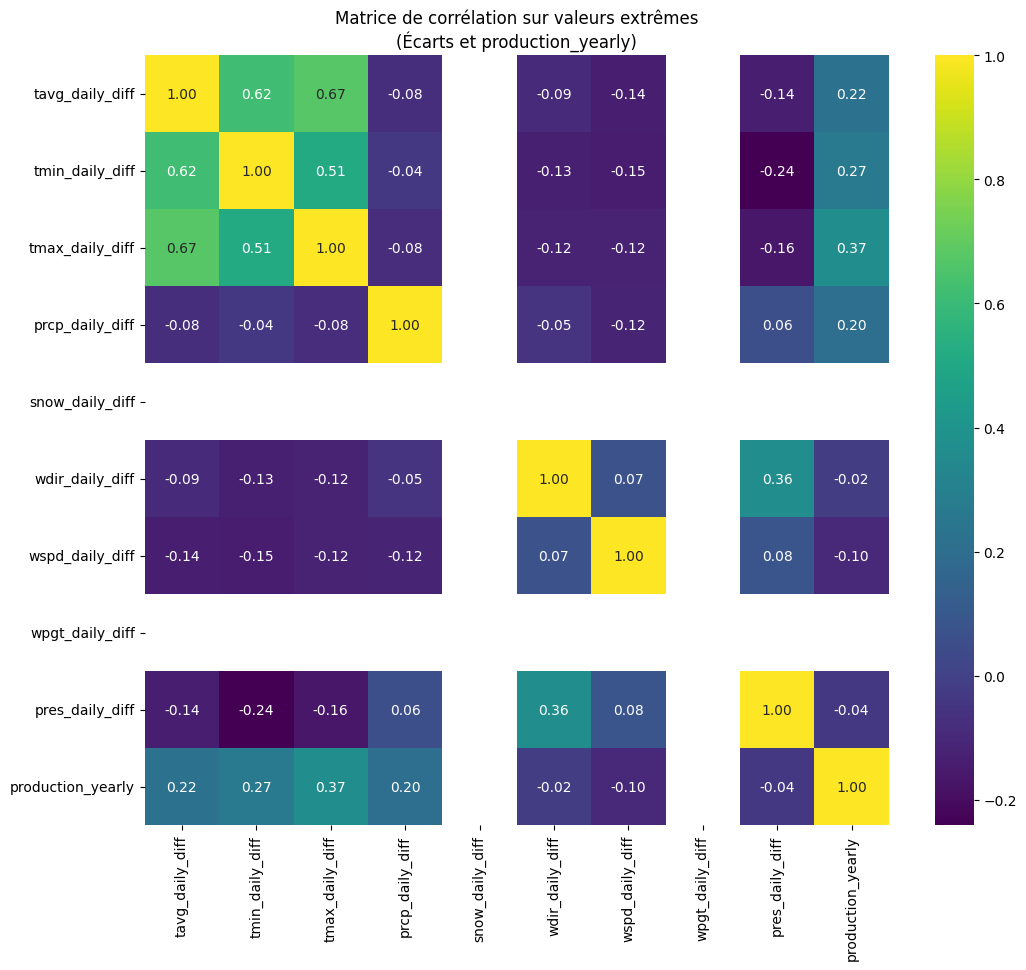


Les résultats des tests sur les valeurs extrêmes ont été enregistrés dans C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_results_quantile.csv


In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# ---------------------------
# 1. Charger le CSV agrégé nettoyé
# ---------------------------
# Remplace ce chemin par celui de ton fichier agrégé nettoyé (par exemple "moyenne_data.csv").
input_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data.csv"
df = pd.read_csv(input_csv, sep=";", low_memory=False)
print("Taille du DataFrame chargé :", df.shape)
print("Colonnes chargées :", df.columns.tolist())

# ---------------------------
# 2. Calcul des colonnes de différence : diff = daily - historical
# On suppose que pour chaque variable météo, la colonne <variable>_historical existe.
weather_vars = ['tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 
                'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily']

for var in weather_vars:
    historical_col = var + "_historical"
    diff_col = var + "_diff"
    if historical_col in df.columns:
        df[diff_col] = df[var] - df[historical_col]
        print(f"Colonne '{diff_col}' calculée pour {var}.")
    else:
        print(f"ATTENTION : la colonne '{historical_col}' est absente. Impossible de calculer '{diff_col}' pour {var}.")

# ---------------------------
# 3. Fonction pour exécuter les tests sur la série de différences extrêmes d'une variable
# ---------------------------
def run_tests_quantile(var, df, lower=0.01, upper=0.99):
    daily_col = var
    historical_col = var + "_historical"
    # Calculer la série de différence (diff = daily - historical)
    diff_series = df[daily_col] - df[historical_col]
    diff_series = diff_series.dropna()
    n_obs = len(diff_series)
    
    # Calculer les quantiles (seuils pour valeurs extrêmes)
    lower_val = diff_series.quantile(lower)
    upper_val = diff_series.quantile(upper)
    
    # Filtrer pour ne conserver que les valeurs extrêmes
    extreme_series = diff_series[(diff_series <= lower_val) | (diff_series >= upper_val)]
    n_extreme = len(extreme_series)
    
    # Test t de Student (H0: moyenne(extreme_series) = 0)
    if n_extreme > 0:
        t_stat, t_p_val = stats.ttest_1samp(extreme_series, popmean=0)
    else:
        t_stat, t_p_val = np.nan, np.nan
    
    # Test ADF pour stationnarité
    try:
        adf_result = adfuller(extreme_series)
        adf_stat = adf_result[0]
        adf_p_val = adf_result[1]
    except Exception as e:
        print(f"Erreur ADF pour {var}: {e}")
        adf_stat, adf_p_val = np.nan, np.nan
        
    # Test Shapiro pour la normalité
    try:
        shapiro_stat, shapiro_p = stats.shapiro(extreme_series)
    except Exception as e:
        print(f"Erreur Shapiro pour {var}: {e}")
        shapiro_stat, shapiro_p = np.nan, np.nan
    
    # Test Jarque-Bera pour la normalité
    try:
        jb_stat, jb_p = stats.jarque_bera(extreme_series)
    except Exception as e:
        print(f"Erreur Jarque-Bera pour {var}: {e}")
        jb_stat, jb_p = np.nan, np.nan
    
    # Test de cointégration entre la variable journalière et production_yearly (si elle existe)
    if 'production_yearly' in df.columns:
        common = df[['production_yearly', daily_col]].dropna()
        if len(common) > 10:
            try:
                _, coint_p, _ = coint(common['production_yearly'], common[daily_col])
            except Exception as e:
                print(f"Erreur cointégration pour {var}: {e}")
                coint_p = np.nan
        else:
            coint_p = np.nan
    else:
        coint_p = np.nan
    
    return {
        'variable': var,
        'n_obs_diff': n_obs,
        'n_obs_extreme': n_extreme,
        'lower_quantile': lower_val,
        'upper_quantile': upper_val,
        't_stat': t_stat,
        't_p_value': t_p_val,
        'adf_stat': adf_stat,
        'adf_p_value': adf_p_val,
        'shapiro_stat': shapiro_stat,
        'shapiro_p_value': shapiro_p,
        'jarque_bera_stat': jb_stat,
        'jarque_bera_p_value': jb_p,
        'coint_p_value': coint_p
    }

# ---------------------------
# 4. Exécuter les tests en parallèle sur toutes les variables (valeurs extrêmes)
# ---------------------------
results_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_tests_quantile)(var, df) for var in weather_vars
)
results_df = pd.DataFrame(results_list)
print("\nRésultats des tests sur les valeurs extrêmes (quantiles 1% et 99%) :")
print(results_df)

# ---------------------------
# 5. Fonction pour extraire les indices extrêmes (uniforme sur toutes les variables)
# ---------------------------
def get_extreme_indices(df, diff_vars, quantile_lower=0.01, quantile_upper=0.99):
    indices = set()
    for col in diff_vars:
        lower_val = df[col].quantile(quantile_lower)
        upper_val = df[col].quantile(quantile_upper)
        idx = df.index[(df[col] <= lower_val) | (df[col] >= upper_val)]
        indices = indices.union(set(idx))
    return list(indices)

# Extraire les indices extrêmes en utilisant nos colonnes de différences
diff_vars = [var + "_diff" for var in weather_vars]
indices_extreme = get_extreme_indices(df, diff_vars, quantile_lower=0.01, quantile_upper=0.99)
print(f"Nombre de lignes extrêmes (union sur toutes les variables) : {len(indices_extreme)}")

# ---------------------------
# 6. Matrices de corrélation sur l'ensemble des données
# a) Corrélation entre les variables journalières et production_yearly
daily_vars = [var for var in weather_vars if var in df.columns]
cols_daily_corr = daily_vars + ['production_yearly']
corr_daily = df[cols_daily_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_daily, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Variables journalières et production_yearly")
plt.show()

# b) Corrélation entre les écarts (daily - historical) et production_yearly
cols_diff_corr = diff_vars + ['production_yearly']
corr_diff = df[cols_diff_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Écarts (daily - historical) et production_yearly")
plt.show()

# ---------------------------
# 7. Matrice de corrélation sur les valeurs extrêmes
# ---------------------------
corr_extreme = df.loc[indices_extreme, cols_diff_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_extreme, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matrice de corrélation sur valeurs extrêmes\n(Écarts et production_yearly)")
plt.show()

# ---------------------------
# 8. Enregistrer les résultats des tests dans un CSV
# ---------------------------
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_results_quantile.csv"
results_df.to_csv(output_csv, sep=";", index=False)
print(f"\nLes résultats des tests sur les valeurs extrêmes ont été enregistrés dans {output_csv}")


2025-04-13 14:19:54,414 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1EBB0E0>


Taille du DataFrame chargé : (3532, 31)
Colonnes chargées : ['country', 'year', 'month', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Colonne 'tavg_daily_diff' calculée pour tavg_daily.
Colonne 'tmin_daily_diff' calculée pour tmin_daily.
Colonne 'tmax_daily_diff' calculée pour tmax_daily.
Colonne 'prcp_daily_diff' calculée pour prcp_daily.
Colonne 'snow_daily_diff' calculée pour snow_daily.
Colonne 'wdir_daily_diff' calculée pour wdir_daily.
Colonne 'wspd_daily_diff' calculée pour wspd_daily.
Colo

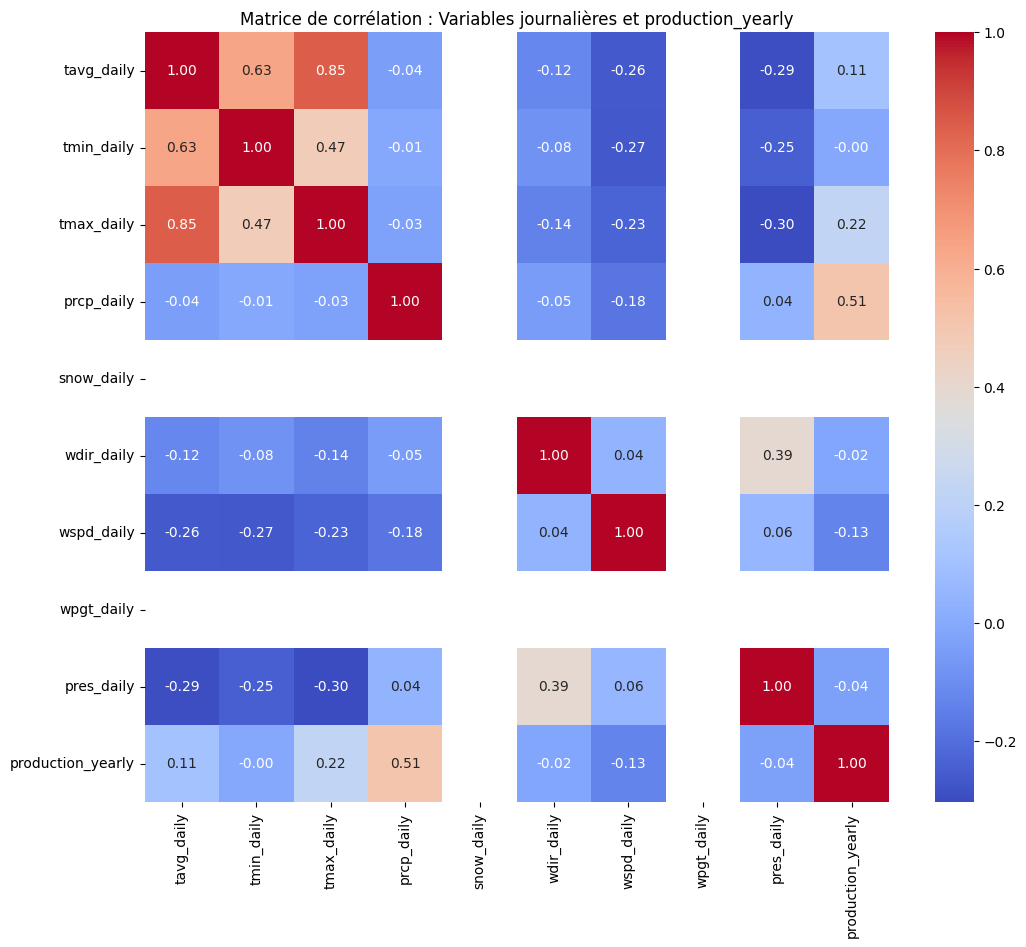

2025-04-13 14:19:55,046 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1A8D4F0>


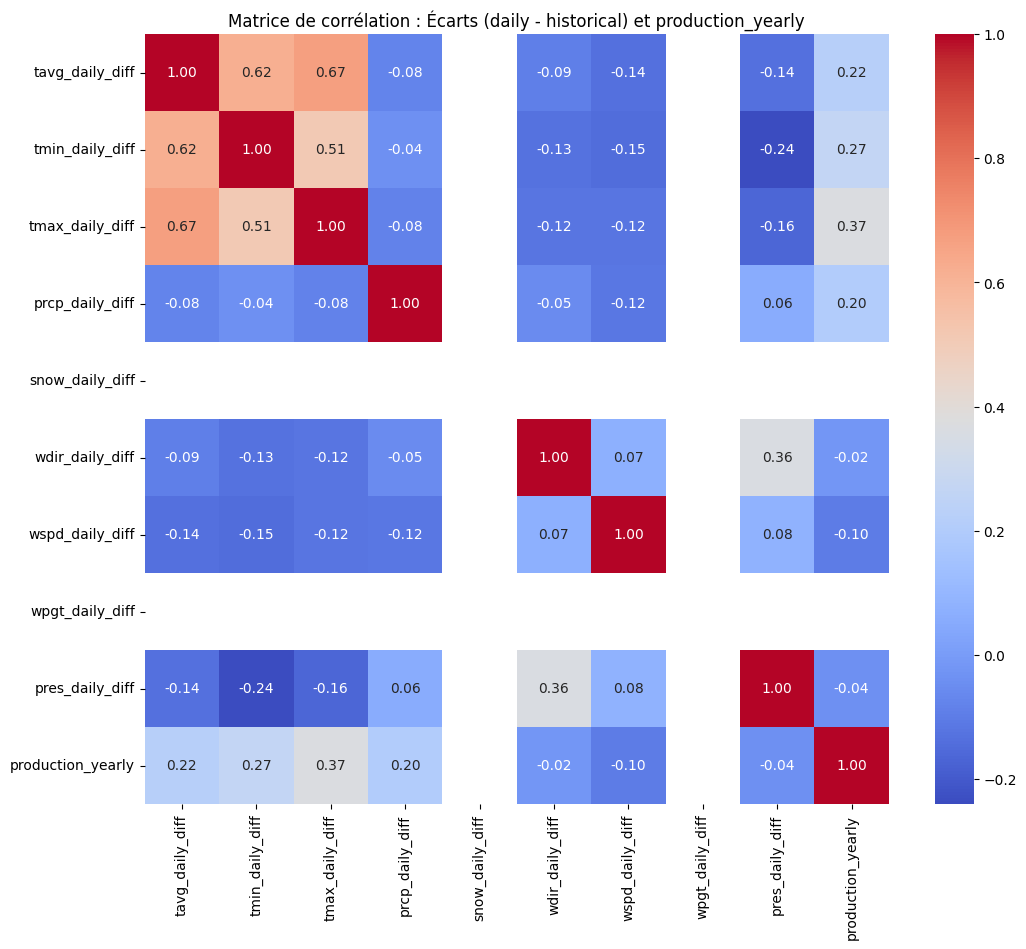

2025-04-13 14:19:55,726 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1D90830>


Matrice de corrélation (valeurs extrêmes) sur les colonnes diff et production_yearly :
                   tavg_daily_diff  tmin_daily_diff  tmax_daily_diff  \
tavg_daily_diff           1.000000         0.621174         0.670360   
tmin_daily_diff           0.621174         1.000000         0.511886   
tmax_daily_diff           0.670360         0.511886         1.000000   
prcp_daily_diff          -0.076578        -0.039110        -0.083832   
snow_daily_diff                NaN              NaN              NaN   
wdir_daily_diff          -0.093080        -0.132502        -0.122681   
wspd_daily_diff          -0.138489        -0.147389        -0.123500   
wpgt_daily_diff                NaN              NaN              NaN   
pres_daily_diff          -0.136437        -0.241005        -0.164482   
production_yearly         0.221310         0.265086         0.367834   

                   prcp_daily_diff  snow_daily_diff  wdir_daily_diff  \
tavg_daily_diff          -0.076578              

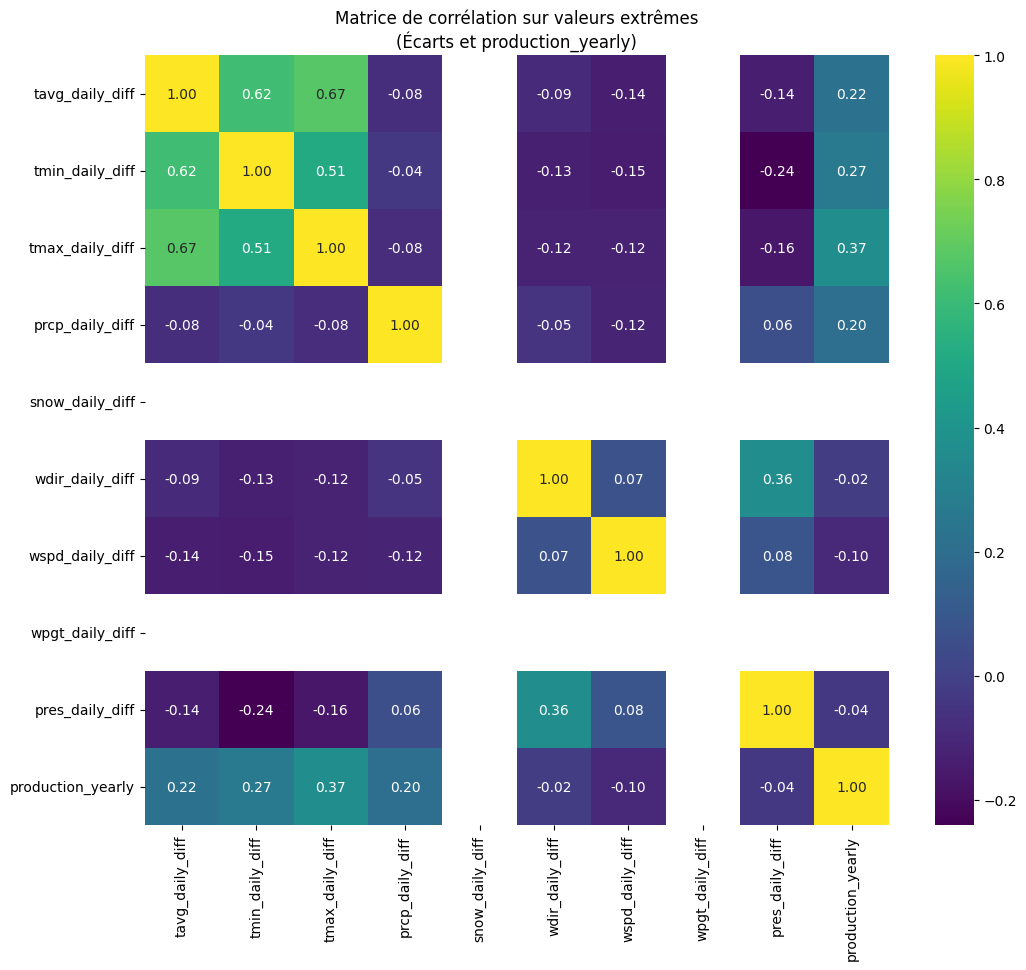

2025-04-13 14:19:56,427 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EA1FD6930>


Matrice de corrélation (valeurs extrêmes) sur les colonnes daily et production_yearly :
                   tavg_daily  tmin_daily  tmax_daily  prcp_daily  snow_daily  \
tavg_daily           1.000000    0.634500    0.845118   -0.039729         NaN   
tmin_daily           0.634500    1.000000    0.470825   -0.008059         NaN   
tmax_daily           0.845118    0.470825    1.000000   -0.031034         NaN   
prcp_daily          -0.039729   -0.008059   -0.031034    1.000000         NaN   
snow_daily                NaN         NaN         NaN         NaN         NaN   
wdir_daily          -0.121478   -0.084588   -0.135666   -0.052586         NaN   
wspd_daily          -0.261494   -0.265170   -0.228163   -0.177778         NaN   
wpgt_daily                NaN         NaN         NaN         NaN         NaN   
pres_daily          -0.293257   -0.247004   -0.303421    0.040947         NaN   
production_yearly    0.108900   -0.004522    0.221457    0.509913         NaN   

                   w

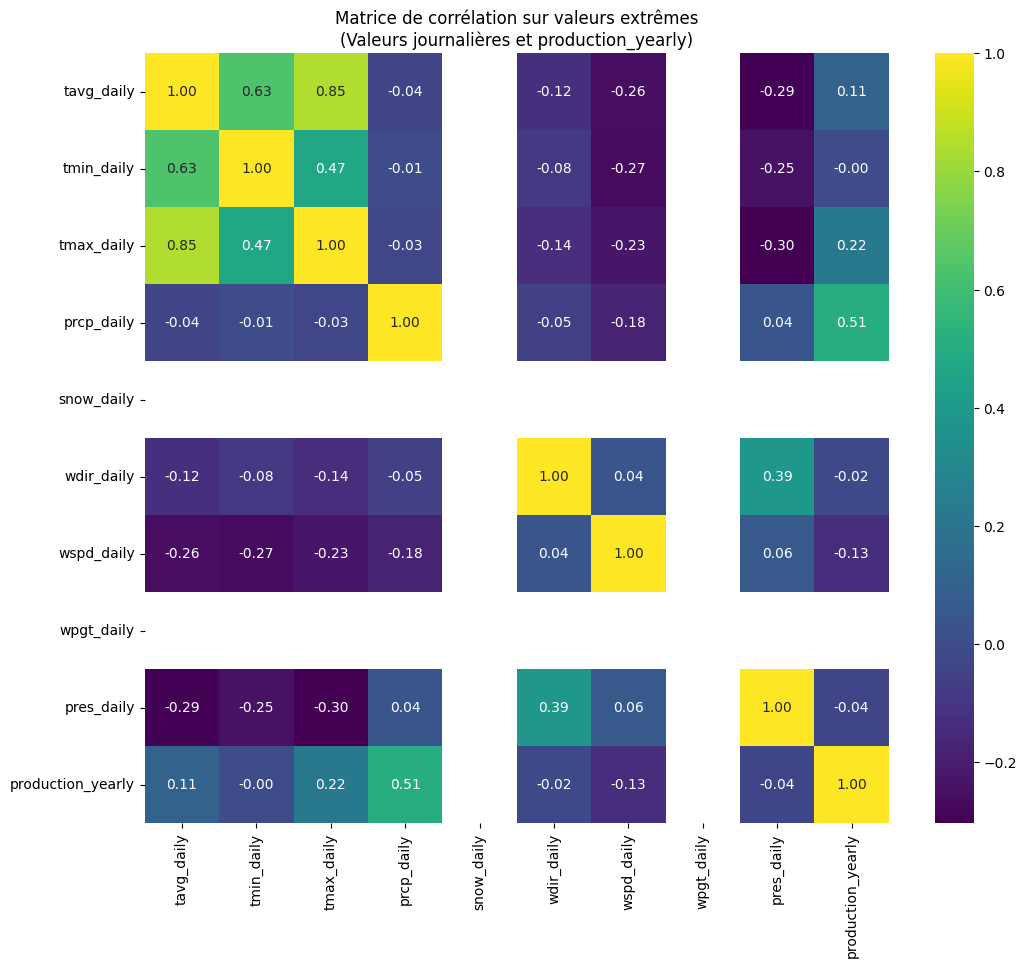


La matrice de corrélation sur les valeurs extrêmes a été enregistrée dans C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_results_quantile.csv


In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# ---------------------------
# 1. Charger le CSV agrégé nettoyé
# ---------------------------
input_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data.csv"
df = pd.read_csv(input_csv, sep=";", low_memory=False)
print("Taille du DataFrame chargé :", df.shape)
print("Colonnes chargées :", df.columns.tolist())

# ---------------------------
# 2. Calcul des colonnes de différence : diff = daily - historical
# On suppose que pour chaque variable météo, la colonne <variable>_historical existe.
weather_vars = ['tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 
                'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily']

for var in weather_vars:
    historical_col = var + "_historical"
    diff_col = var + "_diff"
    if historical_col in df.columns:
        df[diff_col] = df[var] - df[historical_col]
        print(f"Colonne '{diff_col}' calculée pour {var}.")
    else:
        print(f"ATTENTION : la colonne '{historical_col}' est absente. Impossible de calculer '{diff_col}' pour {var}.")

# ---------------------------
# 3. Fonction pour extraire les indices extrêmes d'une liste de colonnes
# ---------------------------
def get_extreme_indices(df, columns, quantile_lower=0.01, quantile_upper=0.99):
    """Retourne l'union des indices pour lesquels les valeurs des colonnes spécifiées
       sont inférieures au quantile quantile_lower ou supérieures au quantile quantile_upper."""
    indices = set()
    for col in columns:
        lower_val = df[col].quantile(quantile_lower)
        upper_val = df[col].quantile(quantile_upper)
        idx = df.index[(df[col] <= lower_val) | (df[col] >= upper_val)]
        indices = indices.union(set(idx))
    return list(indices)

# ---------------------------
# 4. Extraire l'union des indices extrêmes pour les colonnes de différences et les colonnes journalières
# ---------------------------
# Colonnes de différences
diff_vars = [var + "_diff" for var in weather_vars]
# On extrait les indices extrêmes pour les différences
extreme_diff_idx = set(get_extreme_indices(df, diff_vars, quantile_lower=0.01, quantile_upper=0.99))
# On extrait également les indices extrêmes pour les valeurs journalières
extreme_daily_idx = set(get_extreme_indices(df, weather_vars, quantile_lower=0.01, quantile_upper=0.99))
# Union des deux ensembles
indices_extreme = list(extreme_diff_idx.union(extreme_daily_idx))
print(f"Nombre total de lignes extrêmes (union sur diff et valeurs journalières) : {len(indices_extreme)}")

# ---------------------------
# 5. Matrices de corrélation sur l'ensemble des données
# a) Corrélation entre les variables journalières et production_yearly
daily_vars = [var for var in weather_vars if var in df.columns]
cols_daily_corr = daily_vars + ['production_yearly']
corr_daily = df[cols_daily_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_daily, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Variables journalières et production_yearly")
plt.show()

# b) Corrélation entre les écarts (daily - historical) et production_yearly
cols_diff_corr = diff_vars + ['production_yearly']
corr_diff = df[cols_diff_corr].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation : Écarts (daily - historical) et production_yearly")
plt.show()

# ---------------------------
# 6. Matrice de corrélation sur les valeurs extrêmes (concernant à la fois les différences et les valeurs journalières)
# ---------------------------
# On sélectionne les colonnes souhaitées : ici, on combine les colonnes de différences et la production_yearly,
# mais on peut également inclure les variables journalières si nécessaire.
# Par exemple, on peut créer deux matrices : une pour diff + production, et une pour daily + production.
# Ci-dessous, nous montrons la corrélation sur les indices extrêmes pour diff et production_yearly.
cols_extreme_corr = diff_vars + ['production_yearly']
if len(indices_extreme) > 0:
    df_extreme = df.loc[indices_extreme, cols_extreme_corr]
    corr_extreme = df_extreme.corr()
    print("Matrice de corrélation (valeurs extrêmes) sur les colonnes diff et production_yearly :")
    print(corr_extreme)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_extreme, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Matrice de corrélation sur valeurs extrêmes\n(Écarts et production_yearly)")
    plt.show()
else:
    print("Aucun indice extrême trouvé avec les seuils spécifiés.")

# ---------------------------
# 7. Optionnel : Si tu souhaites également la matrice de corrélation sur les extrêmes pour les valeurs journalières et production_yearly
# ---------------------------
cols_extreme_daily_corr = daily_vars + ['production_yearly']
if len(indices_extreme) > 0:
    df_extreme_daily = df.loc[indices_extreme, cols_extreme_daily_corr]
    corr_extreme_daily = df_extreme_daily.corr()
    print("Matrice de corrélation (valeurs extrêmes) sur les colonnes daily et production_yearly :")
    print(corr_extreme_daily)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_extreme_daily, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Matrice de corrélation sur valeurs extrêmes\n(Valeurs journalières et production_yearly)")
    plt.show()
else:
    print("Aucun indice extrême trouvé avec les seuils spécifiés.")

# ---------------------------
# 8. Enregistrer les résultats des tests dans un CSV
# ---------------------------
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\test_results_quantile.csv"
# Si tu souhaites enregistrer uniquement les résultats des tests (par exemple, ceux réalisés par une fonction précédente),
# tu peux enregistrer un DataFrame associé. Ici, nous en enregistrons un éventuel DataFrame de résultats déjà calculé.
# Par exemple, si 'results_df' avait été obtenu via une exécution parallèle.
# results_df.to_csv(output_csv, sep=";", index=False)
# Pour cet exemple, nous enregistrerons la matrice de corrélation sur les valeurs extrêmes.
corr_extreme.to_csv(output_csv, sep=";")
print(f"\nLa matrice de corrélation sur les valeurs extrêmes a été enregistrée dans {output_csv}")


Now lets start the interesting part

Premières lignes du DataFrame:
          X         Y
0 -1.085631  0.000000
1  0.997345 -0.516849
2  0.282978  0.498824
3 -1.506295  1.326734
4 -0.578600 -0.860887


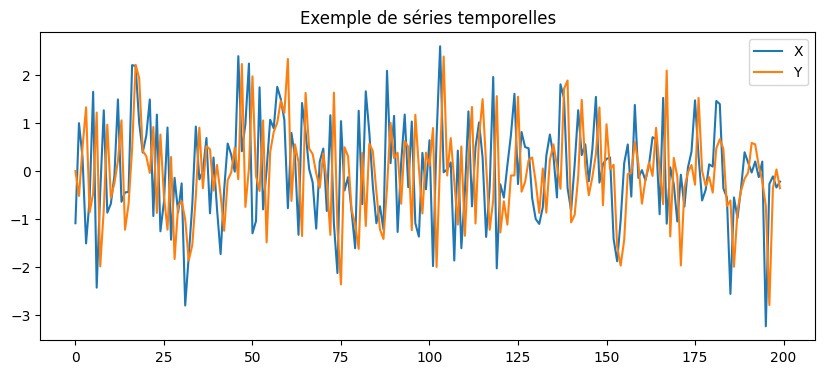


Test de causalité de Granger pour des retards jusqu'à 4 :

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=651.7807, p=0.0000  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=661.7570, p=0.0000  , df=1
likelihood ratio test: chi2=291.4370, p=0.0000  , df=1
parameter F test:         F=651.7807, p=0.0000  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=322.7238, p=0.0000  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=662.1690, p=0.0000  , df=2
likelihood ratio test: chi2=290.8347, p=0.0000  , df=2
parameter F test:         F=322.7238, p=0.0000  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=207.5023, p=0.0000  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=645.4415, p=0.0000  , df=3
likelihood ratio test: chi2=286.2608, p=0.0000  , df=3
parameter F test:         F=207.5023, p=0.0000  , df_denom=190, df_num=3

Granger Causality
number of lags (

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Exemple de génération de deux séries temporelles synthétiques
# On crée deux séries : X et Y
np.random.seed(123)
n_obs = 200
# Série X : bruit blanc
X = np.random.normal(size=n_obs)
# Série Y : dépendante de X avec un décalage (lag 1) plus un terme de bruit
Y = np.zeros(n_obs)
Y[1:] = 0.8 * X[:-1] + np.random.normal(scale=0.5, size=n_obs-1)

# On crée un DataFrame avec ces séries
df = pd.DataFrame({'X': X, 'Y': Y})
print("Premières lignes du DataFrame:")
print(df.head())

# Optionnel : Visualisation des séries
plt.figure(figsize=(10,4))
plt.plot(df['X'], label='X')
plt.plot(df['Y'], label='Y')
plt.title("Exemple de séries temporelles")
plt.legend()
plt.show()

# ---------------------------
# Test de causalité de Granger
# ---------------------------
# Ici, nous testerons si X peut prédire Y.
# Pour le test, il faut créer un DataFrame avec la variable dépendante en première colonne, 
# puis la ou les variables exogènes à tester en colonnes suivantes.
#
# Par exemple, pour tester si les valeurs passées de X aident à prédire Y,
# nous utilisons df[['Y', 'X']].
# maxlag définit le nombre maximum de retards (lags) à considérer.

maxlag = 4  # On teste des lags de 1 à 4
print(f"\nTest de causalité de Granger pour des retards jusqu'à {maxlag} :")
test_result = grangercausalitytests(df[['Y', 'X']], maxlag=maxlag, verbose=True)

# Les résultats de test_result contiennent différentes statistiques pour chaque lag.


Import the price data from Bloomberg

In [21]:
import pandas as pd

# Chemin d'accès à votre fichier CSV Bloomberg
file_path = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg.csv"

# Chargement du fichier en spécifiant un encodage adapté (ici 'latin1') et sans entête (header=None)
df = pd.read_csv(file_path, sep=";", header=None, encoding="latin1", low_memory=False)
print("Aperçu du DataFrame chargé (sans header):")
print(df.head())

# Définir la liste des noms de colonnes souhaités.
# Adaptez cette liste en fonction du nombre de colonnes et de leur signification.
# Par exemple, si votre fichier contient 7 colonnes, vous pouvez utiliser la liste suivante :
nouvelles_colonnes = ["date", "open", "high", "low", "close", "volume", "adj_close"]

# Si le nombre de colonnes du DataFrame ne correspond pas à la longueur de la liste, vérifiez et adaptez.
if len(nouvelles_colonnes) != df.shape[1]:
    print("Attention : le nombre de colonnes proposé ne correspond pas au nombre de colonnes du fichier.")
    print(f"Nombre de colonnes dans le fichier : {df.shape[1]}")
else:
    # Attribuer les nouveaux noms de colonnes
    df.columns = nouvelles_colonnes
    print("Nouvelles colonnes attribuées :")
    print(df.columns.tolist())

# Affichage final
print("Aperçu final du DataFrame avec les nouveaux noms de colonnes:")
print(df.head())


Aperçu du DataFrame chargé (sans header):
                                                  0   \
0  BDH("BCOMCC Index"; "PX_LAST, MATURITY, PX_ASK...   
1  ,5/1/1960,"791,006",,4/1/1991,"1,005,421",,4/1...   
2  ,6/1/1960,"799,908",,7/1/1991,"1,005,965",,5/1...   
3  ,7/1/1960,"789,734",,8/1/1991,"995,177",,6/1/1...   
4  ,8/1/1960,"804,994",,9/1/1991,"993,179",,9/1/1...   

                                  1                2                3   \
0   ""PX_LAST, MATURITY, PX_VOLUME""   ""01/01/1961""   ""04/04/2025""   
1                                NaN              NaN              NaN   
2                                NaN              NaN              NaN   
3                                NaN              NaN              NaN   
4                                NaN              NaN              NaN   

       4                                                  5   \
0  cols=4  rows=8621"")",4/1/1991,"999,337","BDH(""BCOMCC...   
1     NaN                                       

Colonnes avant conversion : ['date', 'Price']

Types de données après conversion :
date     datetime64[ns]
Price           float64
dtype: object


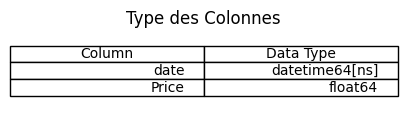


Le fichier CSV a été enregistré avec succès.


In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Chemin complet vers le fichier CSV
file_path = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre.csv"

# Lecture du fichier CSV
df = pd.read_csv(file_path, encoding="cp1252")

print("Colonnes avant conversion :", df.columns.tolist())

# Fonction de conversion personnalisée pour la colonne 'date'
def convert_date(x):
    """
    Convertit la valeur x en datetime.
    Si x représente un nombre (ou une chaîne composée uniquement de chiffres ou chiffres et un point),
    on l'interprète comme un nombre de jours depuis l'origine Excel (1899-12-30).
    Sinon, on suppose que c'est une date au format chaîne et on utilise dayfirst=True.
    """
    s = str(x).strip()
    if s.replace('.', '', 1).isdigit():
        # Conside le nombre comme jours depuis l'origine Excel
        return pd.to_datetime(float(s), unit='D', origin='1899-12-30')
    else:
        return pd.to_datetime(s, dayfirst=True)

# Application de la fonction de conversion sur la colonne 'date'
df['date'] = df['date'].apply(convert_date)

# Fonction de conversion pour la colonne 'Price'
def convert_price(s):
    """
    Convertit une chaîne représentant un prix en float.
    - Si la chaîne contient une virgule suivie d'exactement 3 chiffres, on considère que c'est un séparateur de milliers et on la supprime.
    - Sinon, on remplace la virgule par un point pour une conversion décimale.
    """
    s = str(s).strip()
    if ',' in s:
        parts = s.split(',')
        if len(parts[-1]) == 3:
            s = s.replace(',', '')
        else:
            s = s.replace(',', '.')
    return float(s)

# Conversion de la colonne 'Price'
df['Price'] = df['Price'].apply(convert_price)

# Affichage des types dans la console
print("\nTypes de données après conversion :")
print(df.dtypes)

# Création d'un tableau pour afficher graphiquement les types des colonnes
types_df = df.dtypes.astype(str).reset_index()
types_df.columns = ['Column', 'Data Type']

fig, ax = plt.subplots(figsize=(5, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=types_df.values, colLabels=types_df.columns, loc='center')
plt.title("Type des Colonnes")
plt.show()

# Enregistrement du CSV modifié
df.to_csv(file_path, index=False, encoding="cp1252")
print("\nLe fichier CSV a été enregistré avec succès.")


Index 0: original = 75584.0 => corrigé = 75.584 (exposant -2)
Index 1: original = 74001.0, exposant = -3, corrigé = 74.001, diff = 1.583
Index 2: original = 74958.0, exposant = -3, corrigé = 74.958, diff = 0.957
Index 3: original = 7401.0, exposant = -2, corrigé = 74.010, diff = 0.948
Index 4: original = 73547.0, exposant = -3, corrigé = 73.547, diff = 0.463
Index 5: original = 77047.0, exposant = -3, corrigé = 77.047, diff = 3.500
Index 6: original = 77688.0, exposant = -3, corrigé = 77.688, diff = 0.641
Index 7: original = 77057.0, exposant = -3, corrigé = 77.057, diff = 0.631
Index 8: original = 77062.0, exposant = -3, corrigé = 77.062, diff = 0.005
Index 9: original = 75648.0, exposant = -3, corrigé = 75.648, diff = 1.414
Index 10: original = 75017.0, exposant = -3, corrigé = 75.017, diff = 0.631
Index 11: original = 7534.0, exposant = -2, corrigé = 75.340, diff = 0.323
Index 12: original = 76457.0, exposant = -3, corrigé = 76.457, diff = 1.117
Index 13: original = 75986.0, exposan

2025-04-13 16:15:12,755 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 16:15:13,501 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


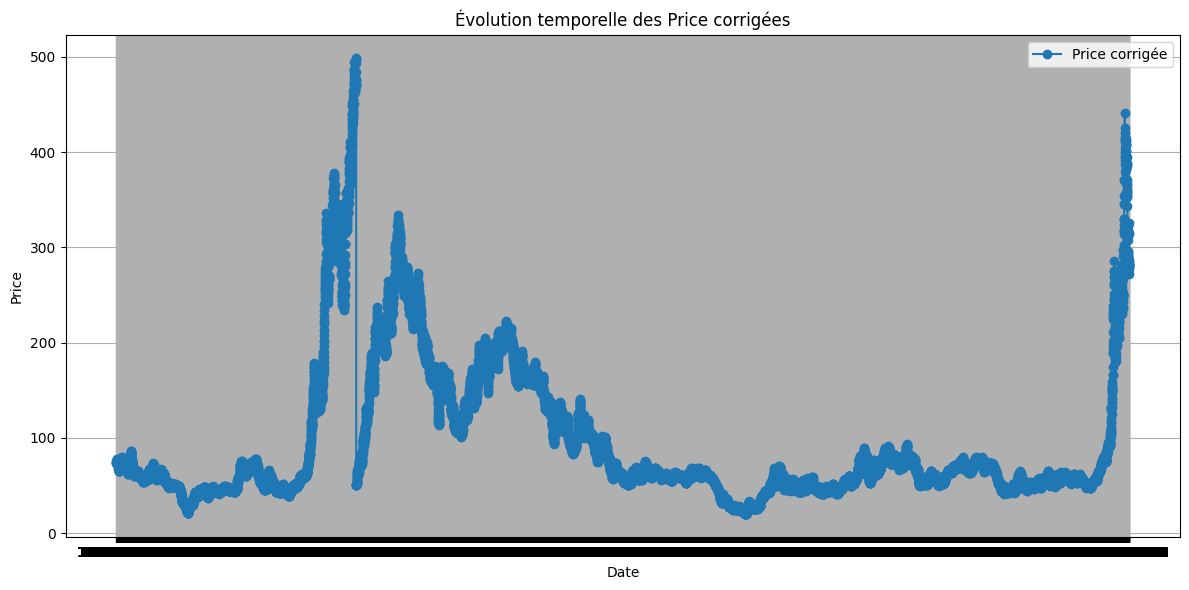

2025-04-13 16:17:37,418 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 16:17:38,431 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


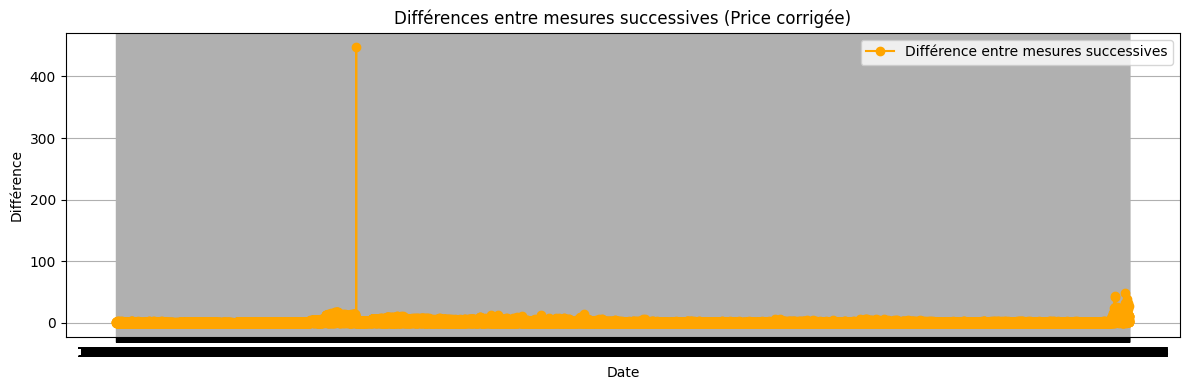


Fichier final sauvegardé sous C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre_corrige.csv


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paramètres ---
MIN_EXP = -6    # plage minimale d'exposants à tester
MAX_EXP = 6     # plage maximale d'exposants à tester
VAL_MIN = 10    # borne inférieure de l'intervalle
VAL_MAX = 500   # borne supérieure de l'intervalle

# --- Lecture du fichier CSV ---
file_path = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre.csv"
df = pd.read_csv(file_path, encoding="cp1252")

# On suppose que le fichier possède déjà les colonnes "date" (au format datetime) et "Price" (en chaîne, à convertir)
# Si ce n'est pas le cas, assurez-vous d'avoir exécuté les étapes préliminaires.

# --- Correction de la colonne Price ---

# Première valeur : la première valeur corrompue est 75584 et devrait devenir 75.584, c'est-à-dire 75584 * 10^-2.
n = len(df)
corrected_prices = np.zeros(n)
chosen_exponents = np.zeros(n, dtype=int)
diffs = np.zeros(n)

# Correction de la première valeur
corrected_prices[0] = df.loc[0, 'Price'] * (10 ** -3)
chosen_exponents[0] = -2
diffs[0] = 0
print(f"Index 0: original = {df.loc[0, 'Price']} => corrigé = {corrected_prices[0]:.3f} (exposant {chosen_exponents[0]})")

# Fonction pour trouver la meilleure correction pour une valeur donnée,
# de sorte que la différence avec la valeur corrigée précédente soit minimale tout en respectant l'intervalle [VAL_MIN, VAL_MAX]
def best_correction(prev, current):
    best_diff = np.inf
    best_candidate = None
    best_exp = None
    for exp in range(MIN_EXP, MAX_EXP+1):
        candidate = current * (10 ** exp)
        if VAL_MIN <= candidate <= VAL_MAX:
            diff = abs(prev - candidate)
            if diff < best_diff:
                best_diff = diff
                best_candidate = candidate
                best_exp = exp
    return best_candidate, best_exp, best_diff

# Correction itérative pour les valeurs suivantes
for i in range(1, n):
    current_val = df.loc[i, 'Price']
    candidate, exp_used, diff_val = best_correction(corrected_prices[i-1], current_val)
    if candidate is None:
        raise ValueError(f"Impossible de corriger la valeur à l'index {i} ({current_val}) pour respecter l'intervalle [{VAL_MIN}, {VAL_MAX}].")
    corrected_prices[i] = candidate
    chosen_exponents[i] = exp_used
    diffs[i] = diff_val
    print(f"Index {i}: original = {current_val}, exposant = {exp_used}, corrigé = {candidate:.3f}, diff = {diff_val:.3f}")

# Ajout des valeurs corrigées et de l'exposant choisi dans le DataFrame final (on garde uniquement date et la valeur corrigée)
df_result = pd.DataFrame({
    'date': df['date'],
    'Price_corrige': corrected_prices
})

# --- Statistiques sur la série corrigée ---
mean_val = np.mean(corrected_prices)
median_val = np.median(corrected_prices)
min_val = np.min(corrected_prices)
max_val = np.max(corrected_prices)

stats_text = f"Moyenne : {mean_val:.2f}\nMédiane : {median_val:.2f}\nMinimum : {min_val:.2f}\nMaximum : {max_val:.2f}"
print("\nStatistiques sur les valeurs corrigées:")
print(stats_text)

# --- Plot des valeurs temporelles corrigées ---
plt.figure(figsize=(12, 6))
plt.plot(df_result['date'], df_result['Price_corrige'], marker='o', linestyle='-', label="Price corrigée")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Évolution temporelle des Price corrigées")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot des différences entre mesures successives ---
plt.figure(figsize=(12, 4))
plt.plot(df_result['date'], diffs, marker='o', linestyle='-', color='orange', label="Différence entre mesures successives")
plt.xlabel("Date")
plt.ylabel("Différence")
plt.title("Différences entre mesures successives (Price corrigée)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optionnel : Sauvegarde du DataFrame final dans un nouveau fichier CSV
output_path = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre_corrige.csv"
df_result.to_csv(output_path, index=False, encoding="cp1252")
print(f"\nFichier final sauvegardé sous {output_path}")


Partie ML 

Ici on va juste laisser un programme OLS trouver le lien entre production et prix et production et meteo

In [84]:
import pandas as pd

# ---------------------------
# Paramètres d'entrée
# ---------------------------
# Chemin du fichier contenant l’historique des prix corrigés du cacao
price_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre_corrige.csv"

# Chemin du fichier contenant la production_yearly, les données météo et les résultats de tests statistiques
prod_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data_hist.csv"

# ---------------------------
# 1. Charger et prétraiter le fichier de prix (historique du cacao)
# ---------------------------
# Ici, on suppose que ce fichier est séparé par des virgules (","), car le contenu indique "date,Price_corrige"
df_price = pd.read_csv(price_file, sep=",", header=0, encoding="cp1252", low_memory=False)
print("Historique des prix chargé – Shape :", df_price.shape)
print("Colonnes du fichier de prix :", df_price.columns.tolist())

# Vérifier que les colonnes sont bien séparées
if "date" not in df_price.columns:
    raise KeyError("La colonne 'date' est absente dans le fichier de prix.")
# Optionnel : renommer la colonne 'Price_corrige' en 'close' pour homogénéiser
if "Price_corrige" in df_price.columns:
    df_price.rename(columns={"Price_corrige": "close"}, inplace=True)
    print("La colonne 'Price_corrige' a été renommée en 'close'.")
    
# Conversion de 'date' en datetime
df_price['date'] = pd.to_datetime(df_price['date'], errors='coerce')
df_price.dropna(subset=['date'], inplace=True)
print("Dates dans le fichier de prix : de", df_price['date'].min(), "à", df_price['date'].max())


# ---------------------------
# 2. Charger et prétraiter le fichier de production/météo
# ---------------------------
df_prod = pd.read_csv(prod_file, sep=";", encoding="latin1", low_memory=False)
print("\nFichier de production/météo chargé – Shape :", df_prod.shape)
print("Colonnes du fichier de production/météo :", df_prod.columns.tolist())

# Vérifier la présence de la colonne 'date'
if "date" not in df_prod.columns:
    raise KeyError("La colonne 'date' est absente dans le fichier de production/météo.")
# Conversion de la colonne 'date' en datetime
df_prod['date'] = pd.to_datetime(df_prod['date'], errors='coerce')
df_prod.dropna(subset=['date'], inplace=True)
print("Dates dans le fichier de production/météo : de", df_prod['date'].min(), "à", df_prod['date'].max())

# ---------------------------
# 3. Traitement des incohérences (exemple)
# ---------------------------
# Si certaines colonnes numériques dans df_prod contiennent des virgules pour les milliers,
# vous pouvez les nettoyer en renseignant leur nom dans la liste suivante.
colonnes_a_nettoyer = []  # Par exemple, ['production_yearly'] si nécessaire
for col in colonnes_a_nettoyer:
    df_prod[col] = df_prod[col].astype(str).str.replace(',', '', regex=False)
    df_prod[col] = pd.to_numeric(df_prod[col], errors='coerce')

# ---------------------------
# 4. Résumé final des DataFrames prétraités
# ---------------------------
print("\n--- Résumé final ---")
print("Prix – Nombre de lignes:", len(df_price))
print("Production/Météo – Nombre de lignes:", len(df_prod))
print("Premières dates dans les prix :", df_price['date'].min(), "-", df_price['date'].max())
print("Premières dates dans la production/météo :", df_prod['date'].min(), "-", df_prod['date'].max())

# Optionnel: Sauvegarder les DataFrames prétraités pour utilisation ultérieure
# df_price.to_csv(r"chemin\vers\fichier_prix_pretraite.csv", sep=";", index=False)
# df_prod.to_csv(r"chemin\vers\fichier_prod_pretraite.csv", sep=";", index=False)


Historique des prix chargé – Shape : (16149, 2)
Colonnes du fichier de prix : ['date', 'Price_corrige']
La colonne 'Price_corrige' a été renommée en 'close'.
Dates dans le fichier de prix : de 1961-01-03 00:00:00 à 2025-04-04 00:00:00

Fichier de production/météo chargé – Shape : (475951, 32)
Colonnes du fichier de production/météo : ['country', 'date', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'year', 'month', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Dates dans le fichier de production/météo : de 1960-01-01 00:00:00 à 2025-04-21 00:0

In [90]:
import pandas as pd

# ---------------------------
# Paramètres d'entrée
# ---------------------------
# Chemin du fichier contenant l’historique des prix corrigés du cacao
price_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\cacao_bloomberg_propre_corrige.csv"

# Chemin du fichier contenant la production_yearly, les données météo et les résultats de tests statistiques
prod_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\moyenne_data_hist.csv"

# ---------------------------
# 1. Charger et prétraiter le fichier de prix (historique du cacao)
# ---------------------------
# Ici, le fichier de prix utilise des virgules comme séparateur (chaque ligne ressemble à : "date,Price_corrige").
df_price = pd.read_csv(price_file, sep=",", header=0, encoding="cp1252", low_memory=False)
print("Historique des prix chargé – Shape :", df_price.shape)
print("Colonnes du fichier de prix :", df_price.columns.tolist())

# Vérifier que les colonnes attendues sont présentes
if "date" not in df_price.columns:
    raise KeyError("La colonne 'date' est absente dans le fichier de prix.")
    
# Optionnel : renommer la colonne 'Price_corrige' en 'close' pour homogénéiser
if "Price_corrige" in df_price.columns:
    df_price.rename(columns={"Price_corrige": "close"}, inplace=True)
    print("La colonne 'Price_corrige' a été renommée en 'close'.")

# Conversion de 'date' en datetime et suppression des lignes si besoin
df_price['date'] = pd.to_datetime(df_price['date'], errors='coerce')
df_price.dropna(subset=['date'], inplace=True)
print("Dates dans le fichier de prix : de", df_price['date'].min(), "à", df_price['date'].max())

# ---------------------------
# 2. Charger et prétraiter le fichier de production/météo
# ---------------------------
df_prod = pd.read_csv(prod_file, sep=";", encoding="latin1", low_memory=False)
print("\nFichier de production/météo chargé – Shape :", df_prod.shape)
print("Colonnes du fichier de production/météo :", df_prod.columns.tolist())

# Vérifier la présence de la colonne 'date'
if "date" not in df_prod.columns:
    if ("year" in df_prod.columns) and ("month" in df_prod.columns):
        # Créer la colonne 'date' en fixant le jour à 1
        df_prod["date"] = pd.to_datetime(df_prod["year"].astype(str) + "-" + 
                                           df_prod["month"].astype(str) + "-01", errors='coerce')
        print("La colonne 'date' a été créée à partir de 'year' et 'month'.")
    else:
        raise KeyError("La colonne 'date' est absente dans le fichier de production/météo, et 'year' et 'month' ne sont pas disponibles.")
else:
    df_prod['date'] = pd.to_datetime(df_prod['date'], errors='coerce')
df_prod.dropna(subset=['date'], inplace=True)
print("Dates dans le fichier de production/météo : de", df_prod['date'].min(), "à", df_prod['date'].max())

# ---------------------------
# 3. Fusionner les DataFrames sur la colonne 'date'
# ---------------------------
# On effectue une fusion outer pour conserver toutes les dates présentes dans l'un ou l'autre DataFrame
df_merged = pd.merge(df_price, df_prod, on='date', how='outer', suffixes=('_price', '_prod'))

# Tri par date pour assurer un alignement temporel correct
df_merged.sort_values(by='date', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

# Affichage du DataFrame fusionné
print("\nShape du DataFrame fusionné :", df_merged.shape)
print("Liste des colonnes fusionnées :", df_merged.columns.tolist())
print("Aperçu du DataFrame fusionné :")
print(df_merged.head(15))
print("\nPlage de dates dans le DataFrame fusionné : de", df_merged['date'].min(), "à", df_merged['date'].max())

# ---------------------------
# 4. Enregistrer le DataFrame fusionné dans un fichier CSV nommé "merged_RNN.csv"
# ---------------------------
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN.csv"
df_merged.to_csv(output_csv, sep=";", index=False)
print(f"\nLe DataFrame fusionné a été sauvegardé dans '{output_csv}'")


Historique des prix chargé – Shape : (16149, 2)
Colonnes du fichier de prix : ['date', 'Price_corrige']
La colonne 'Price_corrige' a été renommée en 'close'.
Dates dans le fichier de prix : de 1961-01-03 00:00:00 à 2025-04-04 00:00:00

Fichier de production/météo chargé – Shape : (475951, 32)
Colonnes du fichier de production/météo : ['country', 'date', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'year', 'month', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Dates dans le fichier de production/météo : de 1960-01-01 00:00:00 à 2025-04-21 00:0

DataFrame fusionné chargé, shape : (475951, 33)
Colonnes disponibles dans le DataFrame : ['date', 'close', 'country', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'year', 'month', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', 'wdir_daily_historical', 'wspd_daily_historical', 'wpgt_daily_historical', 'pres_daily_historical', 'tavg_daily_diff', 'tmin_daily_diff', 'tmax_daily_diff', 'prcp_daily_diff', 'snow_daily_diff', 'wdir_daily_diff', 'wspd_daily_diff', 'wpgt_daily_diff', 'pres_daily_diff']
Colonnes considérées pour l'ordonnée : ['close', 'tavg_daily', 'tmin_daily', 'tmax_daily', 'prcp_daily', 'snow_daily', 'wdir_daily', 'wspd_daily', 'wpgt_daily', 'pres_daily', 'production_yearly', 'tavg_daily_historical', 'tmin_daily_historical', 'tmax_daily_historical', 'prcp_daily_historical', 'snow_daily_historical', '

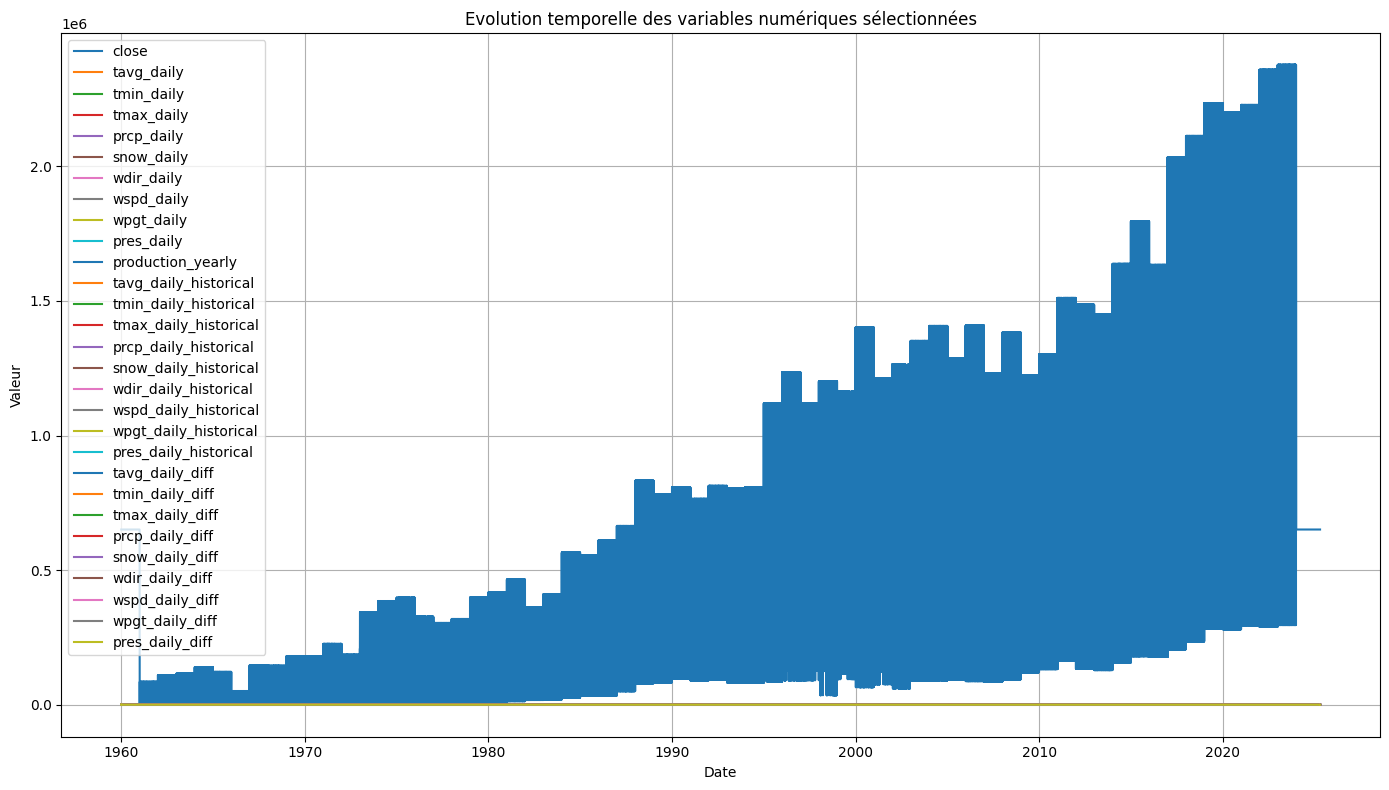

2025-04-13 17:52:55,805 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000015EE53B6FC0>


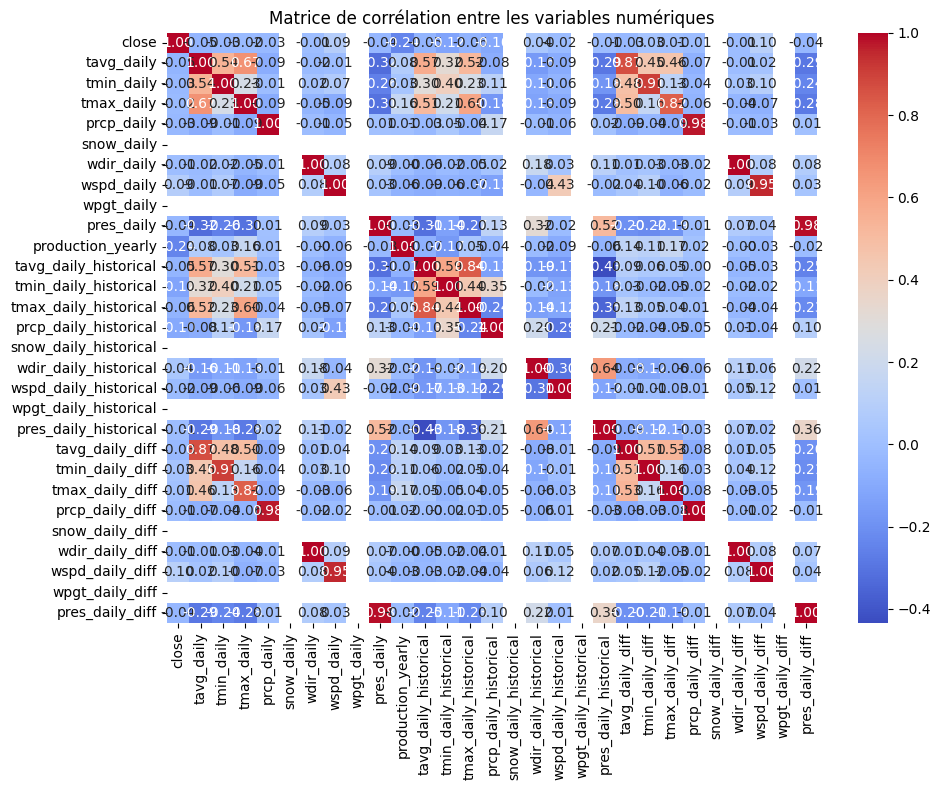

Matrice de corrélation :
                          close  tavg_daily  tmin_daily  tmax_daily  \
close                  1.000000   -0.047998   -0.027937   -0.020327   
tavg_daily            -0.047998    1.000000    0.544744    0.665010   
tmin_daily            -0.027937    0.544744    1.000000    0.233529   
tmax_daily            -0.020327    0.665010    0.233529    1.000000   
prcp_daily            -0.030433   -0.085841   -0.013399   -0.092548   
snow_daily                  NaN         NaN         NaN         NaN   
wdir_daily            -0.008088   -0.021171    0.019622   -0.050347   
wspd_daily             0.089131   -0.009754    0.069991   -0.088140   
wpgt_daily                  NaN         NaN         NaN         NaN   
pres_daily            -0.038643   -0.322819   -0.256298   -0.307192   
production_yearly     -0.239946    0.079470    0.032284    0.160907   
tavg_daily_historical -0.051474    0.573769    0.301254    0.513852   
tmin_daily_historical -0.123251    0.319676    0.399

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le DataFrame fusionné
merged_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN.csv"
df = pd.read_csv(merged_file, sep=";", low_memory=False)
print("DataFrame fusionné chargé, shape :", df.shape)

# Conversion de la colonne 'date' en datetime (si nécessaire)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)

# Afficher les colonnes disponibles
print("Colonnes disponibles dans le DataFrame :", df.columns.tolist())

# ---------------------------
# Visualisation des séries temporelles
# ---------------------------
plt.figure(figsize=(14, 8))

# On ne trace qu'un sous-ensemble de colonnes : les colonnes de type numérique (float, int)
# et on exclut 'date' elle-même ainsi que 'country'.
num_cols = [col for col in df.columns 
            if pd.api.types.is_numeric_dtype(df[col])  # colonne numérique
            and col not in ['year', 'month']          # optionnel : exclure year, month 
            and col != 'date']                        # exclure la colonne date
# Ex: si vous ne voulez pas tracer 'production_yearly_historical' ou d'autres colonnes, excluez-les ici.

print("Colonnes considérées pour l'ordonnée :", num_cols)

for col in num_cols:
    plt.plot(df['date'], df[col], label=col)

plt.xlabel("Date")
plt.ylabel("Valeur")
plt.title("Evolution temporelle des variables numériques sélectionnées")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Calcul et affichage de la matrice de corrélation
# ---------------------------
# On sélectionne les colonnes de type numérique parmi num_cols pour calculer la corrélation
df_corr = df[num_cols].dropna()

# Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation entre les variables numériques")
plt.tight_layout()
plt.show()

print("Matrice de corrélation :")
print(corr_matrix)


DataFrame fusionné chargé, shape : (475951, 33)
Colonnes à normaliser : ['RAG_signal', 'close', 'close_lag1', 'close_lag2', 'close_lag3', 'close_rollmean_14', 'close_rollmean_7', 'month', 'month_cos', 'month_sin', 'prcp_daily', 'prcp_daily_diff', 'prcp_daily_historical', 'prcp_daily_lag1', 'prcp_daily_lag2', 'prcp_daily_lag3', 'pres_daily', 'pres_daily_diff', 'pres_daily_historical', 'production_yearly', 'production_yearly_diff', 'production_yearly_lag1', 'production_yearly_lag2', 'production_yearly_lag3', 'production_yearly_rollmean_14', 'production_yearly_rollmean_7', 'snow_daily', 'snow_daily_diff', 'snow_daily_historical', 'tavg_daily', 'tavg_daily_diff', 'tavg_daily_historical', 'tavg_daily_lag1', 'tavg_daily_lag2', 'tavg_daily_lag3', 'tmax_daily', 'tmax_daily_diff', 'tmax_daily_historical', 'tmin_daily', 'tmin_daily_diff', 'tmin_daily_historical', 'wdir_daily', 'wdir_daily_diff', 'wdir_daily_historical', 'weekday', 'weekday_cos', 'weekday_sin', 'wpgt_daily', 'wpgt_daily_diff', 'w

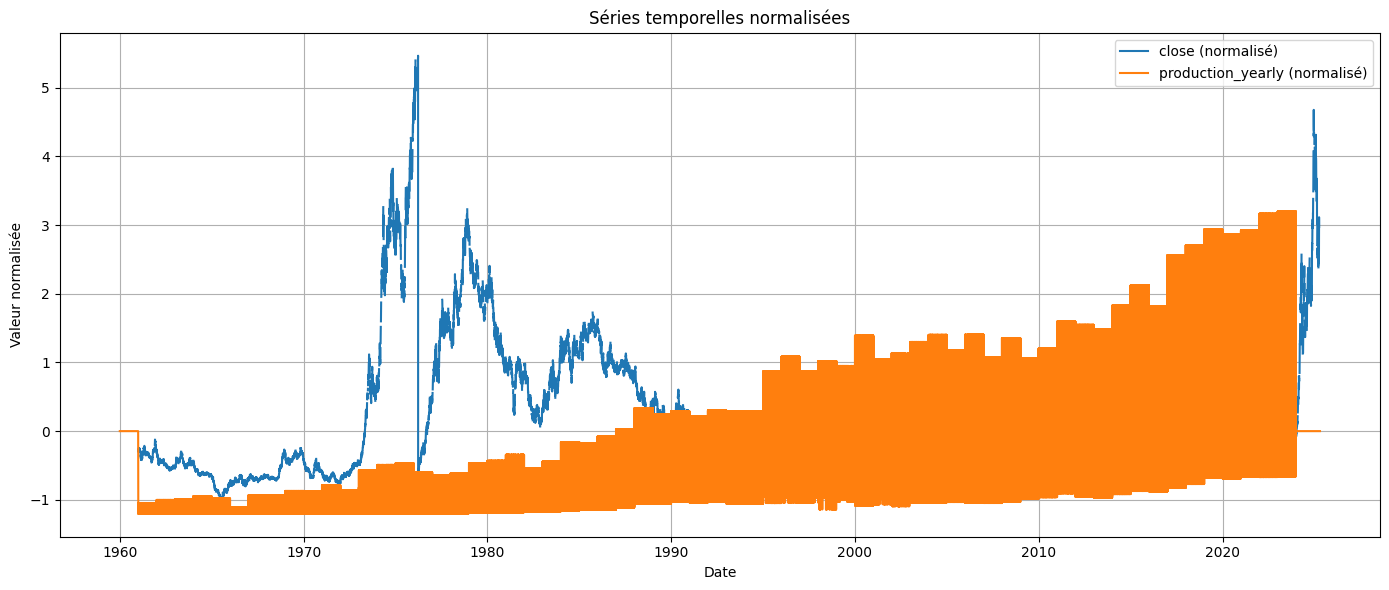


Le fichier final préparé pour le RNN a été sauvegardé dans 'C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN_features.csv'


In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Chargement du DataFrame fusionné (issu du Prompt 2)
# ---------------------------
merged_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN.csv"
df = pd.read_csv(merged_file, sep=";", low_memory=False)
print("DataFrame fusionné chargé, shape :", df.shape)

# Conversion de la colonne 'date' en datetime (au cas où ce ne soit pas déjà fait)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by='date', inplace=True)
df.reset_index(drop=True, inplace=True)

# ---------------------------
# 1. Génération de features temporelles
# ---------------------------

# 1.1 Création de features de lags pour les variables importantes
# On définit les variables pour lesquelles on souhaite créer des lags.
variables_lag = ['close', 'production_yearly', 'tavg_daily', 'prcp_daily']
n_lags = 3  # par exemple, on crée 3 lags

for var in variables_lag:
    if var in df.columns:
        for lag in range(1, n_lags+1):
            df[f'{var}_lag{lag}'] = df[var].shift(lag)
    else:
        print(f"ATTENTION: La variable '{var}' n'est pas présente dans le DataFrame.")

# 1.2 Calcul des moyennes mobiles (rolling mean) sur 7 et 14 jours
rolling_windows = [7, 14]
for var in ['close', 'production_yearly']:
    if var in df.columns:
        for win in rolling_windows:
            df[f'{var}_rollmean_{win}'] = df[var].rolling(window=win, min_periods=1).mean()

# 1.3 Création d'indicateurs de saisonnalité à partir du mois
# Transformation sinus/cosinus pour capturer la cyclicalité des mois
if 'month' in df.columns:
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Vous pouvez aussi ajouter d'autres features temporelles, comme le jour de la semaine
df['weekday'] = df['date'].dt.weekday  # 0 = lundi, 6 = dimanche
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# ---------------------------
# 2. Création d'indicateurs basés sur les résultats statistiques (exemple de RAG)
# ---------------------------
# Exemple simple basé sur la différence de production annuelle ('production_yearly').
# On calcule la différence (si non déjà présente) et ensuite on définit un signal :
#    - 1 si la variation est supérieure à un seuil positif,
#    - -1 si la variation est inférieure à un seuil négatif,
#    - 0 sinon.
if 'production_yearly' in df.columns:
    # Calculer la différence journalière ou selon l'intervalle temporel (si c'est annuelle, adapter)
    df['production_yearly_diff'] = df['production_yearly'].diff()
    # Définir des seuils (à ajuster en fonction de l'échelle de vos données)
    seuil_positif = df['production_yearly_diff'].quantile(0.75)
    seuil_negatif = df['production_yearly_diff'].quantile(0.25)
    def definir_rag(val):
        if pd.isna(val):
            return 0
        if val > seuil_positif:
            return 1
        elif val < seuil_negatif:
            return -1
        else:
            return 0
    df['RAG_signal'] = df['production_yearly_diff'].apply(definir_rag)
else:
    print("La variable 'production_yearly' est absente, impossible de créer un RAG_signal.")

# ---------------------------
# 3. Normalisation et mise à l’échelle
# ---------------------------
# Nous allons normaliser les features qui seront utilisées pour l'entraînement du RNN.
# Exclure la colonne 'date' de la normalisation et potentiellement les identifiants textuels.
colonnes_a_normaliser = df.columns.difference(['date', 'country'])  # On exclut 'date' et 'country'
# Convertir en liste (optionnel)
colonnes_a_normaliser = list(colonnes_a_normaliser)
print("Colonnes à normaliser :", colonnes_a_normaliser)

# Appliquer le StandardScaler de scikit-learn
scaler = StandardScaler()
df_norm = df.copy()
df_norm[colonnes_a_normaliser] = scaler.fit_transform(df_norm[colonnes_a_normaliser])

# ---------------------------
# 4. Visualisation de quelques séries transformées
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(df_norm['date'], df_norm['close'], label="close (normalisé)")
plt.plot(df_norm['date'], df_norm['production_yearly'], label="production_yearly (normalisé)")
plt.xlabel("Date")
plt.ylabel("Valeur normalisée")
plt.title("Séries temporelles normalisées")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# 5. Sauvegarde du DataFrame final préparé pour le RNN
# ---------------------------
# Nous conservons uniquement la colonne date et toutes les features (normalisées) qui seront utilisées pour l'entraînement.
# Vous pouvez adapter la sélection des colonnes selon votre stratégie de modélisation.
colonnes_finales = ['date'] + colonnes_a_normaliser
df_final = df_norm[colonnes_finales].copy()
output_csv = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN_features.csv"
df_final.to_csv(output_csv, sep=";", index=False)
print(f"\nLe fichier final préparé pour le RNN a été sauvegardé dans '{output_csv}'")


In [105]:
import pandas as pd

# Chemin du fichier CSV volumineux
merged_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN_features.csv"

# Définir un chunksize plus petit (ici 5 000 lignes par chunk)
chunksize = 5000

chunks = []
print("Début de la lecture par chunks avec engine='python' et chunksize =", chunksize, "...")
try:
    # Lecture par chunks avec le moteur Python
    for chunk in pd.read_csv(merged_file, sep=";", chunksize=chunksize, engine='python'):
        chunks.append(chunk)
    # Concaténer les chunks pour obtenir le DataFrame final
    df = pd.concat(chunks, ignore_index=True)
    print("Fichier chargé par chunks, shape :", df.shape)
except Exception as e:
    print("Erreur lors de la lecture par chunks :", e)
    raise

# Libérer la mémoire associée à la liste des chunks
del chunks

# ---------------------------
# Prétraitement du DataFrame
# ---------------------------
# Conversion de la colonne 'date' en datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Suppression des lignes dont la conversion a échoué
    df.dropna(subset=['date'], inplace=True)
    # Tri par date
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Plage de dates dans le DataFrame :", df['date'].min(), "à", df['date'].max())
else:
    print("La colonne 'date' n'est pas présente dans le DataFrame.")

# Affichage rapide des premières lignes
print("Aperçu du DataFrame final :")
print(df.head())


Début de la lecture par chunks avec engine='python' et chunksize = 5000 ...
Fichier chargé par chunks, shape : (475951, 55)
Plage de dates dans le DataFrame : 1960-01-01 00:00:00 à 2025-04-21 00:00:00
Aperçu du DataFrame final :
        date  RAG_signal  close  close_lag1  close_lag2  close_lag3  \
0 1960-01-01    0.007299    NaN         NaN         NaN         NaN   
1 1960-01-01    0.007299    NaN         NaN         NaN         NaN   
2 1960-01-01    0.007299    NaN         NaN         NaN         NaN   
3 1960-01-01    0.007299    NaN         NaN         NaN         NaN   
4 1960-01-01    0.007299    NaN         NaN         NaN         NaN   

   close_rollmean_14  close_rollmean_7     month  month_cos  ...   weekday  \
0                NaN               NaN -1.590522   1.226282  ...  0.503602   
1                NaN               NaN -1.590522   1.226282  ...  0.503602   
2                NaN               NaN -1.590522   1.226282  ...  0.503602   
3                NaN            

In [108]:
import pandas as pd

# ---------------------------
# 1. Lecture par chunks du dataset final préparé pour le RNN
# ---------------------------
merged_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\merged_RNN_features.csv"

# Définir la taille d'un chunk (ici, 5000 lignes par chunk)
chunksize = 5000
chunks = []

print("Début de la lecture par chunks avec engine='python' et chunksize =", chunksize, "...")
try:
    # Lire le CSV par morceaux sans low_memory pour éviter l'erreur
    for chunk in pd.read_csv(merged_file, sep=";", chunksize=chunksize, engine="python"):
        chunks.append(chunk)
    # Concaténer tous les chunks en un seul DataFrame
    df_final = pd.concat(chunks, ignore_index=True)
    print("Fichier chargé par chunks, shape :", df_final.shape)
except Exception as e:
    print("Erreur lors de la lecture par chunks :", e)
    raise

# Libérer la liste de chunks
del chunks

# ---------------------------
# 2. Prétraitement des dates
# ---------------------------
if 'date' not in df_final.columns:
    raise KeyError("La colonne 'date' est absente dans le dataset.")
    
# Conversion de 'date' en format datetime
df_final['date'] = pd.to_datetime(df_final['date'], errors='coerce')

# Suppression des lignes dont la conversion a échoué
df_final.dropna(subset=['date'], inplace=True)

# Tri du DataFrame par date pour garantir la continuité temporelle
df_final.sort_values(by='date', inplace=True)
df_final.reset_index(drop=True, inplace=True)

print("Plage de dates dans le dataset :", df_final['date'].min(), "à", df_final['date'].max())

# ---------------------------
# 3. Division du dataset en ensembles d'entraînement, validation et test
# ---------------------------
# Nous utilisons la méthode de découpage par indices pour respecter l'ordre chronologique
n = len(df_final)
train_end = int(0.70 * n)  # 70 % pour l'entraînement
val_end = int(0.85 * n)    # 15 % pour la validation et 15 % pour le test

df_train = df_final.iloc[:train_end].copy()
df_val = df_final.iloc[train_end:val_end].copy()
df_test = df_final.iloc[val_end:].copy()

print("\nRépartition du dataset :")
print(f"Entraînement : {len(df_train)} lignes")
print(f"Validation  : {len(df_val)} lignes")
print(f"Test        : {len(df_test)} lignes")

print("\nPlage de dates :")
print("Entraînement :", df_train['date'].min(), "à", df_train['date'].max())
print("Validation  :", df_val['date'].min(), "à", df_val['date'].max())
print("Test        :", df_test['date'].min(), "à", df_test['date'].max())

# ---------------------------
# 4. Sauvegarde des ensembles dans des fichiers CSV
# ---------------------------
train_file = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_train.csv"
val_file   = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_val.csv"
test_file  = r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_test.csv"

df_train.to_csv(train_file, sep=";", index=False)
df_val.to_csv(val_file, sep=";", index=False)
df_test.to_csv(test_file, sep=";", index=False)

print("\nLes ensembles d'entraînement, validation et test ont été sauvegardés :")
print("Train :", train_file)
print("Val   :", val_file)
print("Test  :", test_file)


Début de la lecture par chunks avec engine='python' et chunksize = 5000 ...
Fichier chargé par chunks, shape : (475951, 55)
Plage de dates dans le dataset : 1960-01-01 00:00:00 à 2025-04-21 00:00:00

Répartition du dataset :
Entraînement : 333165 lignes
Validation  : 71393 lignes
Test        : 71393 lignes

Plage de dates :
Entraînement : 1960-01-01 00:00:00 à 2017-02-12 00:00:00
Validation  : 2017-02-12 00:00:00 à 2022-02-23 00:00:00
Test        : 2022-02-23 00:00:00 à 2025-04-21 00:00:00

Les ensembles d'entraînement, validation et test ont été sauvegardés :
Train : C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_train.csv
Val   : C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_val.csv
Test  : C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\dataset_test.csv


In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Chargement du dataset construit pour le RNN (par exemple, à partir de fichiers .npy)
# Assurez-vous que ces fichiers existent et sont générés lors du prétraitement
X = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\X_RNN.npy", mmap_mode='r')
y = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\y_RNN.npy", mmap_mode='r')

print("X shape:", X.shape)  # Par exemple, (nombre_exemples, window_size, nombre_de_features)
print("y shape:", y.shape)  # Par exemple, (nombre_exemples,)

# Définir des variables à partir des shapes du dataset
window_size = X.shape[1]    # Taille de la fenêtre d'entrée
num_features = X.shape[2]   # Nombre de features

# Définition de l'architecture du modèle RNN
model = Sequential()

# Première couche LSTM avec 64 neurones. return_sequences=True permet de renvoyer toute la séquence, nécessaire pour empiler une deuxième couche LSTM.
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
model.add(Dropout(0.2))  # Dropout pour réduire le surapprentissage

# Deuxième couche LSTM avec 32 neurones. Ici, return_sequences est laissé par défaut (False) pour ne renvoyer que la dernière sortie.
model.add(LSTM(32))
model.add(Dropout(0.2))

# Couche Dense finale à sortie unique (prévision du prix ou d'un signal)
model.add(Dense(1))

# Choix de l'optimiseur et de la fonction de perte
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Affichage du résumé du modèle
model.summary()


X shape: (475921, 30, 53)
y shape: (475921,)


C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,657 (166.63 KB)

 Trainable params: 42,657 (166.63 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import numpy as np

print("Nombre de NaN dans X :", np.isnan(X).sum())
print("Nombre de NaN dans y :", np.isnan(y).sum())
print("Nombre de +inf dans X :", np.isposinf(X).sum())
print("Nombre de -inf dans X :", np.isneginf(X).sum())
print("Nombre de +inf dans y :", np.isposinf(y).sum())
print("Nombre de -inf dans y :", np.isneginf(y).sum())



Nombre de NaN dans X : 20445961
Nombre de NaN dans y : 149455
Nombre de +inf dans X : 0
Nombre de -inf dans X : 0
Nombre de +inf dans y : 0
Nombre de -inf dans y : 0


In [6]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Charger les tableaux X et y en utilisant mmap_mode 'r' pour limiter la mémoire
X = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\X_RNN.npy", mmap_mode='r')
y = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\y_RNN.npy", mmap_mode='r')

print("X shape:", X.shape)  # Exemple : (475921, 30, 53)
print("y shape:", y.shape)  # Exemple : (475921,)

# Définition d'une fonction qui applique le forward fill sur une séquence 2D
def forward_fill_sequence(seq):
    # Convertir la séquence en DataFrame
    df_seq = pd.DataFrame(seq)
    # Appliquer un forward fill sur les lignes (axis=0) afin de remplir les NaN avec la dernière valeur valide
    df_seq_filled = df_seq.ffill(axis=0)
    # Optionnel : Backward fill, pour combler les éventuelles valeurs manquantes au début de la séquence
    df_seq_filled = df_seq_filled.bfill(axis=0)
    return df_seq_filled.values

# Définition d'une fonction pour un forward fill sur un tableau 1D (pour y)
def forward_fill_1d(arr):
    s = pd.Series(arr)
    s_filled = s.ffill().bfill()
    return s_filled.values

# Appliquer le forward fill sur X en parallèle (n_jobs=-1 pour utiliser tous les cœurs)
num_sequences = X.shape[0]
print("Début du forward fill sur X...")

X_filled_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(forward_fill_sequence)(X[i]) for i in range(num_sequences)
)
# Convertir la liste de séquences en tableau NumPy (on conserve le même dtype que X, par exemple float32 ou float64)
X_filled = np.array(X_filled_list, dtype=X.dtype)

# Appliquer le forward fill sur y
y_filled = forward_fill_1d(y)

print("Nombre de NaN dans X_filled :", np.isnan(X_filled).sum())
print("Nombre de NaN dans y_filled :", np.isnan(y_filled).sum())

# Sauvegarder les tableaux imputés dans de nouveaux fichiers
np.save(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\X_RNN_filled.npy", X_filled)
np.save(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\y_RNN_filled.npy", y_filled)

print("Les tableaux imputés ont été sauvegardés.")


X shape: (475921, 30, 53)
y shape: (475921,)
Début du forward fill sur X...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18437243542213236s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06304216384887695s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07230806350708008s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.6s
[Parallel(n_job

Nombre de NaN dans X_filled : 4100700
Nombre de NaN dans y_filled : 0
Les tableaux imputés ont été sauvegardés.


In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------------------------
# 1. Chargement des données
# ---------------------------
# Chargement des fichiers .npy contenant les séquences d'entrée X et la cible y.
X = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\X_RNN_filled.npy", mmap_mode='r')
y = np.load(r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\y_RNN_filled.npy", mmap_mode='r')
print("X shape:", X.shape)  # Par exemple (475921, 30, 53)
print("y shape:", y.shape)  # Par exemple (475921,)

# ---------------------------
# 2. Filtrer les séquences contenant des NaN
# ---------------------------
# Création d'un masque booléen qui vaut True pour les séquences sans NaN.
mask = ~np.isnan(X).any(axis=(1, 2))
n_valid = np.sum(mask)
print("Nombre de séquences valides (sans NaN) :", n_valid)

# Extraire uniquement ces séquences valides, ainsi que les cibles associées
X_valid = X[mask]
y_valid = y[mask]

# ---------------------------
# 3. Division du dataset en ensembles d’entraînement, de validation et de test
# ---------------------------
n_total = X_valid.shape[0]
train_end = int(0.70 * n_total)  # 70% pour l'entraînement
val_end = int(0.85 * n_total)    # 15% pour la validation, 15% pour le test

X_train = X_valid[:train_end]
y_train = y_valid[:train_end]
X_val = X_valid[train_end:val_end]
y_val = y_valid[train_end:val_end]
X_test = X_valid[val_end:]
y_test = y_valid[val_end:]

print(f"Entraînement : {X_train.shape[0]} séquences")
print(f"Validation  : {X_val.shape[0]} séquences")
print(f"Test        : {X_test.shape[0]} séquences")

# ---------------------------
# 4. Définition de l'architecture du modèle RNN
# ---------------------------
window_size = X_valid.shape[1]    # Par exemple : 30 jours
num_features = X_valid.shape[2]   # Par exemple : 53 features

model = Sequential()
# Première couche LSTM avec 64 neurones qui renvoie la séquence complète pour empiler une autre couche LSTM
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
model.add(Dropout(0.2))
# Deuxième couche LSTM avec 32 neurones
model.add(LSTM(32))
model.add(Dropout(0.2))
# Couche de sortie Dense pour prédire une valeur (par exemple, le prix)
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()

# ---------------------------
# 5. Entraînement du modèle RNN
# ---------------------------
# Utilisation d'EarlyStopping et ModelCheckpoint pour surveiller la performance sur l'ensemble de validation
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint(
        r"C:\Users\Home\Documents\ESILV\A4\S2\commo\como_cacao\best_model.keras",
        monitor='val_loss', save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

test_loss = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)


X shape: (475921, 30, 53)
y shape: (475921,)
Nombre de séquences valides (sans NaN) : 444727
Entraînement : 311308 séquences
Validation  : 66709 séquences
Test        : 66710 séquences


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,657 (166.63 KB)

 Trainable params: 42,657 (166.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - loss: 0.0279 - val_loss: 0.0153
Epoch 2/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 108s 22ms/step - loss: 0.0095 - val_loss: 0.0407
Epoch 3/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0089 - val_loss: 0.1185
Epoch 4/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0090 - val_loss: 0.0976
Epoch 5/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 108s 22ms/step - loss: 0.0088 - val_loss: 0.0936
Epoch 6/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0085 - val_loss: 0.7611
Epoch 7/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0085 - val_loss: 0.7599
Epoch 8/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0084 - val_loss: 0.0041
Epoch 9/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 10/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 11/100
4865/4865 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - loss: 0.0085 - val